# CIS 545 Final Project - Anime and MyAnimeList User Preferences 📺🌈

####Maya Patel, Carolyn Ryan, Hannah Xiao


In 2009, Netflix offered $1M to any team that could predict user ratings for films better than Netflix already did.  Since then, streaming services have only gotten more relevent to our culture and daily lives.  Streaming services are always looking to recommend their users enjoyable content so that they can stay in business.

We analyzed data from MyAnimeList, a website where anime fans can research, discuss, and log anime that interests them or that they have watched.  The goal of this project was to cluster users based on their demographics and/or anime preferences to identify distinct customer groups.  Then, with further EDA, we searched for the genres of anime that users in each cluster were interested in.

Hypothetically, user groups and tailored anime recommendation would be relevant to a streaming service such as Crunchyroll, which hosts anime on their platform.

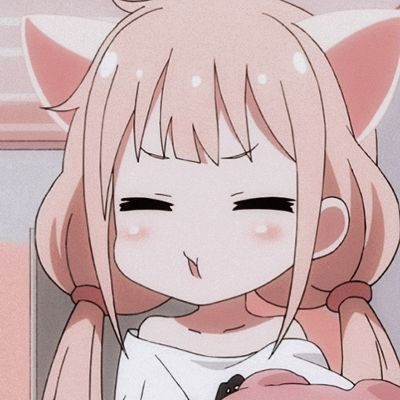

### 0: Setup and installation
Be sure to upload a kaggle.json file to the Colab environment.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
from datetime import date
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d azathoth42/myanimelist

In [ ]:
!unzip /content/myanimelist.zip

In [ ]:
# Set up Spark
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [6]:
import pyspark
from pyspark.sql import SQLContext
from pyspark import SparkFiles

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [ ]:
!apt install libkrb5-dev
!pip install sparkmagic

In [8]:
%load_ext sparkmagic.magics

In [9]:
spark = SparkSession.builder.appName('final').getOrCreate()
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

## 1: Initial Exploratory Data Analysis
MyAnimeList users can record and reivew anime that they have watched or are interested in through the "My Anime List" feature of the website.  They can:


*   Add anime they are itnerested in
*   Update how many episodes they have watched
*   Mark an anime as dropped, on hold, or finished
*   Rank an anime from 1-10

According to the website, anime with the most number of people who add it to their lists are the most popular.

This data was scraped from MyAnimeList on around May 10th, 2018 and was published on Kaggle.  The unique user IDs were scraped from a list of forum topics, and the user information was scraped using this user ID list.  Therefore, our sample is comrpised of passionate anime fans and public enough about their love to post in forum threads.



### 1.1: Loading the Data
We have 4 dataframes from the website:


1.   *anime_df*


> Contains information of each specific anime, including its title, number and average length of episodes, score, number of members who added it to their list, and when it was aired.  There are 6,668 entries.


2.   *userlist_df*


> Contains basic user information (gender, date of birth, date they joined the site, latest time online) and the number of anime in each category of their list (watching, completed, on hold, dropped, plan to watch)


3.   *myanimelist_df*


> Contains every anime added by every user to their lists.  Each row contains the name of the anime, the sore given, and the watching status of the user (corresponding to the categories listed in userlist_df)


4.   *location_df*


> Contains the cleaned locaton data of each user, including the country, country code, state, and city if applicable.








We first read in the CSVs and save them as Pandas dataframes.

In [10]:
anime_cols = ['anime_id', 'title', 'source', 'episodes', 'aired_string', 'rating', 'score', 'scored_by', 'rank', 'popularity', 'members', 'favorites', 'premiered', 'producer', 'studio', 'genre', 'duration_min', 'aired_from_year']
anime_df = pd.read_csv('anime_cleaned.csv', usecols=anime_cols)

In [11]:
userlist_cols = ['username', 'user_id', 'user_watching', 'user_completed', 'user_onhold','user_dropped', 'user_plantowatch', 'user_days_spent_watching','gender','birth_date','join_date','last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes']
userlist_df = pd.read_csv('users_cleaned.csv', usecols=userlist_cols)

In [12]:
myanimelist_cols = ['username', 'anime_id', 'my_watched_episodes', 'my_score', 'my_status', 'my_rewatching','my_rewatching_ep', 'my_last_updated']
myanimelist_df = pd.read_csv('animelists_cleaned.csv', usecols=myanimelist_cols)

In [13]:
location_cols = ['user_id', "country", 'state', 'city', 'country_code']
location_df = pd.read_csv('clean-locations.csv', usecols=location_cols)

Later on, we use Spark due to the size of the table and limitations of Colab's RAM.  We will read in some CSVs and save them as Spark dataframes.

In [14]:
anime_sdf = spark.read.format("csv").option("header", "true").load("/content/anime_cleaned.csv")
anime_sdf = anime_sdf.select(anime_cols)
anime_sdf.createOrReplaceTempView("anime")

In [15]:
myanimelist_sdf = spark.read.format("csv").option("header", "true").load("/content/animelists_cleaned.csv")
myanimelist_sdf = myanimelist_sdf.select(myanimelist_cols)
myanimelist_sdf.createOrReplaceTempView("myanimelist")

In [16]:
userlist_sdf = spark.read.format("csv").option("header", "true").load("/content/users_cleaned.csv")
userlist_sdf = userlist_sdf.select(userlist_cols)
userlist_sdf.createOrReplaceTempView("userlist")

### 1.2: Understanding user habits: how many hours do users spend watching anime?

How much anime does each user tend to watch?  How passionate are these fans who use MyAnimeList?  We measured how many users (y) spent a given number of days (x) watching anime.

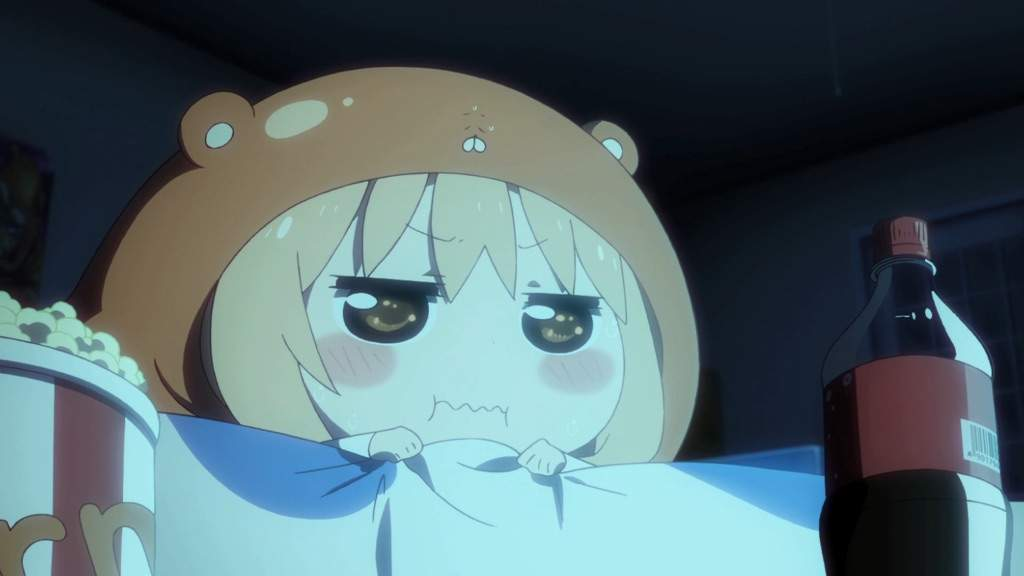

In [17]:
ys = [i+1 for i in range(9)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 <a list of 7 Text major ticklabel objects>)

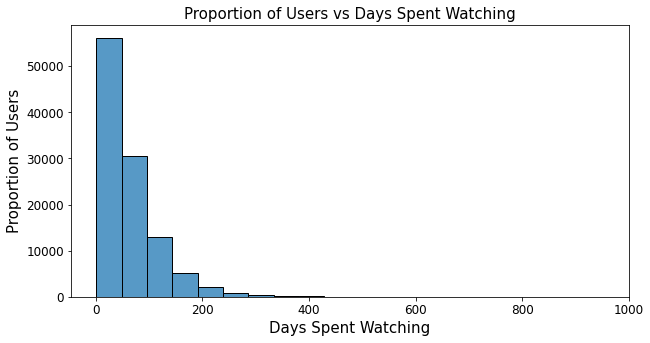

In [18]:
plt.rcParams['figure.figsize']=(10,5)

sns.histplot(data=userlist_df['user_days_spent_watching'], bins = 20, palette = colors)

plt.title('Proportion of Users vs Days Spent Watching', fontsize=15 )
plt.ylabel('Proportion of Users', fontsize=15)
plt.xlabel('Days Spent Watching', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

### 1.3: Understanding User Habits: User List Analysis
Understanding how users use MyAnimeList is an important first step to find different clusters of consumption using fan data.

#### 1.3.1: Number of Shows per Category on User List
How many shows does each person tend to add to their list?  We created empirical cumulative distribution plots to display how many users (y) contained some number of anime (x) on their list for a given category.

According to the website, the mapping from *my_status* integers to status is:


1.   Watching
2.   Completed
3.   On hold
4.   Dropped
5.   N/A
6.   Plan to watch



In [19]:
# First, count all of the shows on each user's list regardless of status
myanimelist_count_df_total = myanimelist_df.groupby('username').count()

In [20]:
# Next, count all of the shows on each user's list with respect to a status
def list_count_df_status(status_int, col_name):
  myanimelist_count_df_status = myanimelist_df[myanimelist_df['my_status'] == status_int].groupby('username').count().sort_values('anime_id')[['anime_id']].rename(columns={"anime_id": col_name})
  
  # Represent every user in case some do not have any anime in a status category 
  myanimelist_count_df_status = myanimelist_count_df_status.append(pd.DataFrame([0]*(len(myanimelist_count_df_total.index)-len(myanimelist_count_df_status.index)),columns=[col_name]))
  return myanimelist_count_df_status

myanimelist_count_df_watching = list_count_df_status(1, "Number of Anime Watching")
myanimelist_count_df_completed = list_count_df_status(2, "Number of Anime Completed")
myanimelist_count_df_on_hold = list_count_df_status(3, "Number of Anime On Hold")
myanimelist_count_df_dropped = list_count_df_status(4, "Number of Anime Dropped")
myanimelist_count_df_plan_to_watch = list_count_df_status(6, "Number of Anime Plan to Watch")  

In [21]:
myanimelist_count_df_total[['number_listed']] = myanimelist_count_df_total[['anime_id']]
myanimelist_count_df_total = myanimelist_count_df_total[['number_listed']].sort_values('number_listed')
myanimelist_count_df_total = myanimelist_count_df_total.rename(columns = {"number_listed": "Number of Animes Listed"})

/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar inst

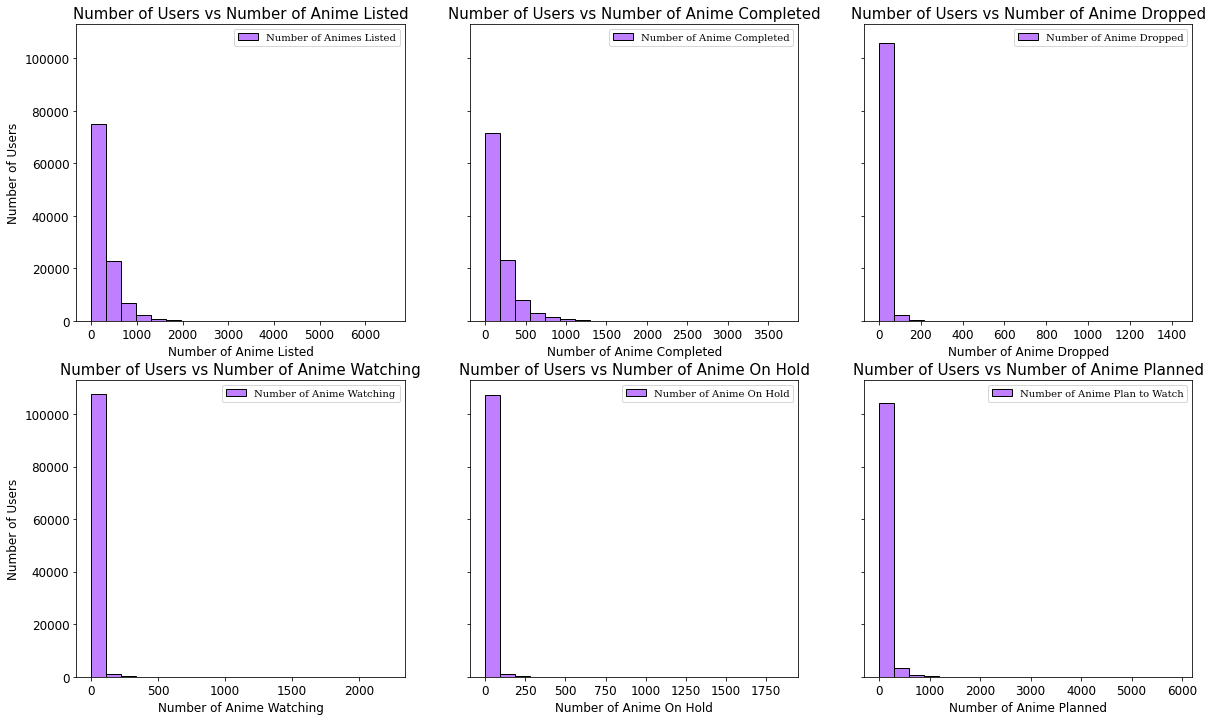

In [22]:
# Setup layout / aesthetics for 6 subplots
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,12))
plt.rcParams.update({'font.family':'Serif'})
plt.rcParams['figure.figsize']=(10,5)

# Draw histplot at a point on the canvas
def histplot(i, j, df, status):
  sns.histplot(data=df, ax=axes[i][j], bins=20, palette=colors)
  axes[i][j].set_title(f"Number of Users vs Number of Anime {status}", fontsize=15)
  axes[i][j].set_ylabel("Number of Users", fontsize=12)
  axes[i][j].set_xlabel(f"Number of Anime {status}", fontsize=12)
  axes[i][j].tick_params(axis='both', which='major', labelsize=12)

histplot(0, 0, myanimelist_count_df_total, "Listed")
histplot(1, 0, myanimelist_count_df_watching, "Watching")
histplot(0, 1, myanimelist_count_df_completed, "Completed")
histplot(1, 1, myanimelist_count_df_on_hold, "On Hold")
histplot(0, 2, myanimelist_count_df_dropped, "Dropped")
histplot(1, 2, myanimelist_count_df_plan_to_watch, "Planned")

According to these plots, the vast majority of users add a "reasonable" number of anime to each category.  Some superfans add hundreds or even thousands more.

For example, the majority of users add less than a few hundred anime to their list in total.  A very small number of people have added almost every anime on the site!

#### 1.3.2: Mean/Median per Category on User List
To understand the average user, we ploted the mean and median number of anime that each user added to each category in their lists.

In [23]:
# First, clean the column names for plot aesthetics
userlist_clean_df = userlist_df.rename(columns = {'user_watching': "Watching"	,'user_completed': "Completed",	'user_onhold': "On Hold",	'user_dropped': "Dropped",	'user_plantowatch': "Plan to Watch"})

In [24]:
# Then, obtain the mean and median for each category
median_count_df = pd.DataFrame({"Number": userlist_clean_df[['Watching'	,'Completed',	'On Hold',	'Dropped',	'Plan to Watch']].median()})
median_count_df['Statistic'] = 'median'

mean_count_df = pd.DataFrame({"Number": userlist_clean_df[['Watching'	,'Completed',	'On Hold',	'Dropped',	'Plan to Watch']].mean()})
mean_count_df['Statistic'] = 'mean'

mean_median_count_df = pd.concat([median_count_df, mean_count_df])
mean_median_count_df = mean_median_count_df.reset_index()

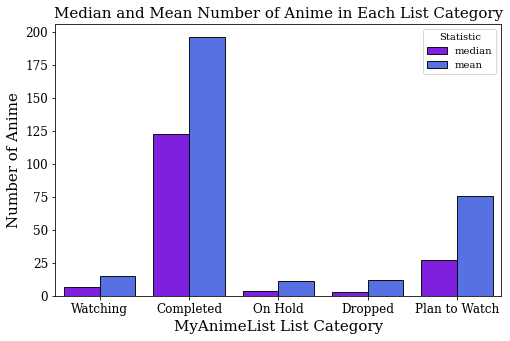

In [25]:
plt.rcParams['figure.figsize']=(8,5)

sns.barplot(x="index", y="Number", hue="Statistic", data=mean_median_count_df, palette = colors, linewidth=.9, edgecolor = "black")

plt.title('Median and Mean Number of Anime in Each List Category', fontsize=15)
plt.ylabel('Number of Anime', fontsize=15)
plt.xlabel('MyAnimeList List Category', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

As expected, the mean of each category is larger than the median.  The aforementioned superfans add many more shows than the average user and impact the mean.

The median user watches around 5 shows at a time, has watched 125 anime, has dropped and put a couple on hold, and plans to watch around 25 anime.

Because the number of anime that users have dropped is so low compared to the number that they have completed, plan to watch, or is watching, we assume that *users indicate interest in anime by adding them to their lists*.

#### 1.3.3: How does the score of an anime affect how many people add it to their lists?

#####1.3.3.1: Scatterplot
We plotted the score of an anime (x) versus the number of users who have added it to their lists (y).  Each point represents 1 show from anime_df.

We can get a sense of how good/well-liked a show is by looking at this relationship, and perhaps a sense of how overrated/underrated shows are according to MyAnimeList.

In [ ]:
# First, get the score and number of members (in millions) for each anime.
anime_popularity_df = anime_df[['score', 'members']]
anime_popularity_df['members'] = anime_popularity_df['members'].div(1000000)

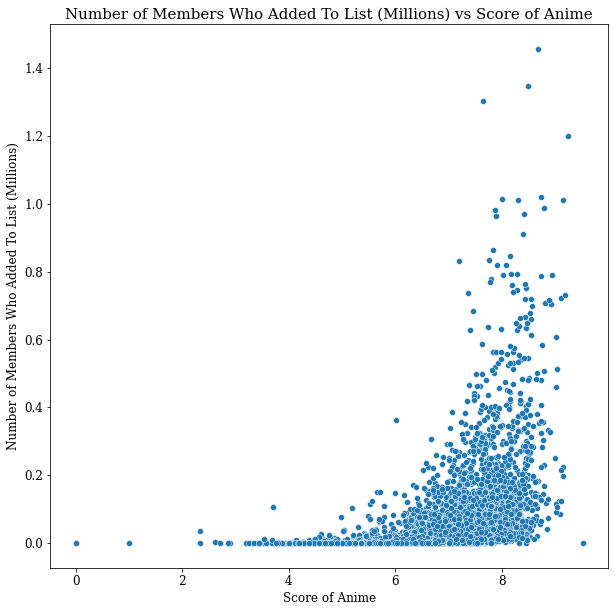

In [27]:
plt.rcParams['figure.figsize']=(10,10)

sns.scatterplot(data=anime_popularity_df, x="score", y="members", palette = colors)
plt.title('Number of Members Who Added To List (Millions) vs Score of Anime', fontsize=15)
plt.ylabel('Number of Members Who Added To List (Millions)', fontsize=12)
plt.xlabel('Score of Anime', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Clearly, the vast majority of anime that are highly added have scores around 7 and above.

Several anime have been added many more times than other anime with the same average score. 

There are many anime clustered near the x axis, making it difficult to see the true scope of the spread.

##### 1.3.3.2: Heatmaps
To get a better look, we plot the data on a heatmap, with the intensity of the color of each cell corresponding to the number of shows in that cell.

In [28]:
def draw_heatmap(x, y, title, xlabel, ylabel, bins):
  plt.rcParams['figure.figsize']=(10,10)
  
  plt.hist2d(x, y, bins=bins, cmap=plt.cm.jet)
  
  cbar = plt.colorbar()
  cbar.ax.tick_params(labelsize=12)

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  plt.title(title, fontsize=15)
  plt.ylabel(ylabel, fontsize=15)
  plt.xlabel(xlabel, fontsize=15)
  plt.show()

In [29]:
# Process score and member data for heatmap rendering
anime_scores_numpy = anime_df['score'].astype(float).to_numpy()
anime_members_numpy = anime_df['members'].div(1000000).astype(float).to_numpy()

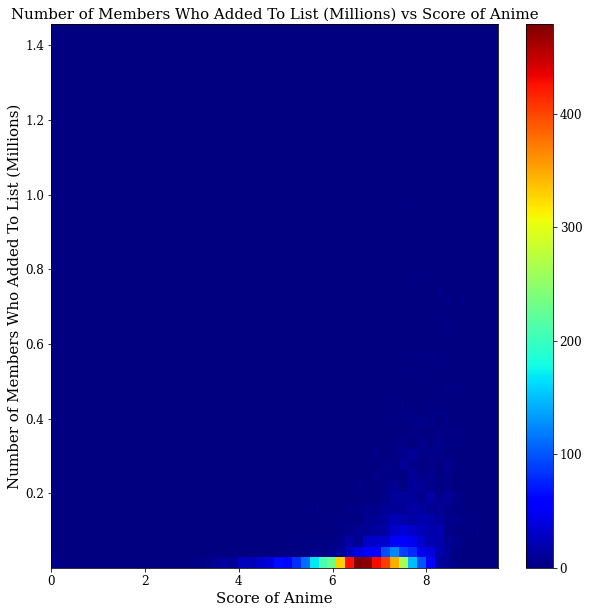

Percent of anime on the website = 1.0


In [30]:
draw_heatmap(anime_scores_numpy, anime_members_numpy, 'Number of Members Who Added To List (Millions) vs Score of Anime', 'Score of Anime', 'Number of Members Who Added To List (Millions)', bins=(50,50))
print('Percent of anime on the website = ' + str(len(anime_df.index)/len(anime_df.index)))

Creating the scatterplot as a heat map shows how highly concentrated most animes are in terms of the number of users who added it and its score. The vast majority of animes are added by less than 100k, and have scores between 5 and 8. 

Let us zoom in further to see if there may be any deeper pattern within the large cluster. 

In [31]:
anime_zoom1_df = anime_df[anime_df['score'] > 5]
anime_zoom1_df = anime_zoom1_df[anime_zoom1_df['score'] < 8]
anime_zoom1_df = anime_zoom1_df[anime_zoom1_df['members'] < 100000]

anime_scores_numpy = anime_zoom1_df['score'].astype(float).to_numpy()
anime_members_numpy = anime_zoom1_df['members'].div(1000000).astype(float).to_numpy()

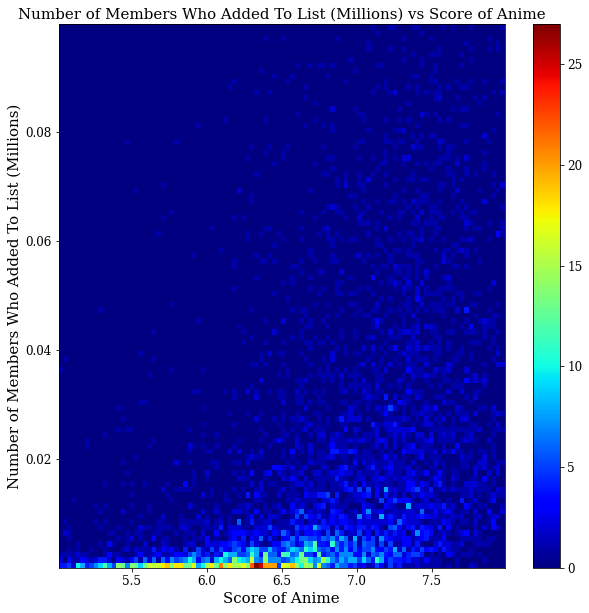

Number of animes shown = 5312
Percent of animes on the website = 0.797


In [32]:
draw_heatmap(anime_scores_numpy, anime_members_numpy, 'Number of Members Who Added To List (Millions) vs Score of Anime', 'Score of Anime', 'Number of Members Who Added To List (Millions)', (100, 100))
print('Number of animes shown = ' + str(len(anime_zoom1_df.index)))
print('Percent of animes on the website = ' + str(round(len(anime_zoom1_df.index)/len(anime_df.index), 3)))

Zooming into a square that represents 3% of the entire graph yields a heatmap that contains 82.7% of all animes on the site. This illustrates how most animes are okay, having a score between 5 and 8, but are watched by very few people. To see the true extent, we zoom in one last time.

In [33]:
anime_zoom1_df = anime_df[anime_df['score'] > 5]
anime_zoom1_df = anime_zoom1_df[anime_zoom1_df['score'] < 8]
anime_zoom1_df = anime_zoom1_df[anime_zoom1_df['members'] < 10000]

anime_scores_numpy = anime_zoom1_df['score'].astype(float).to_numpy()
anime_members_numpy = anime_zoom1_df['members'].astype(float).to_numpy()

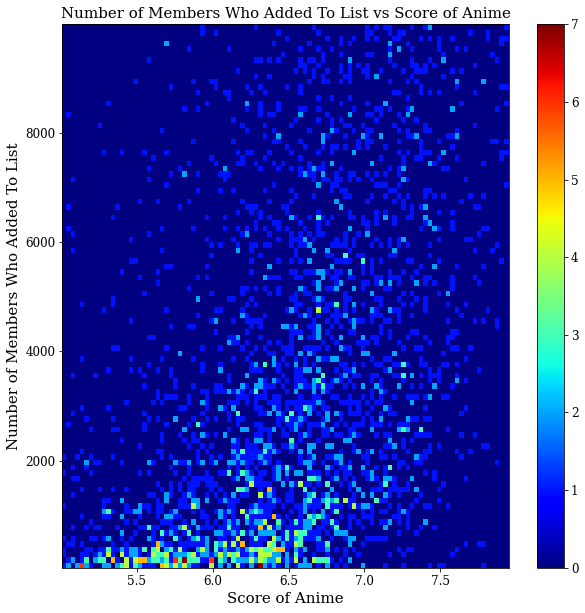

Number of animes shown = 3029


In [34]:
draw_heatmap(anime_scores_numpy, anime_members_numpy, 'Number of Members Who Added To List vs Score of Anime', 'Score of Anime', 'Number of Members Who Added To List', (100, 100))
print('Number of animes shown = ' + str(len(anime_zoom1_df.index)))

This final zoom reveals that around 50% of all animes on the site are located in this .3% of the graph. This graph view also shows some very small clusters of less than 7 animes that were previously obscured, but these are likely small enough to not be meaningful. 

### 1.4: Top 20 Shows based on User Lists
Let's get a sense of which shows are the most popular on MyAnimeList.  What are the top 20 shows, judging by how many people have added it to their lists?  How many people have added each of them to their lists?
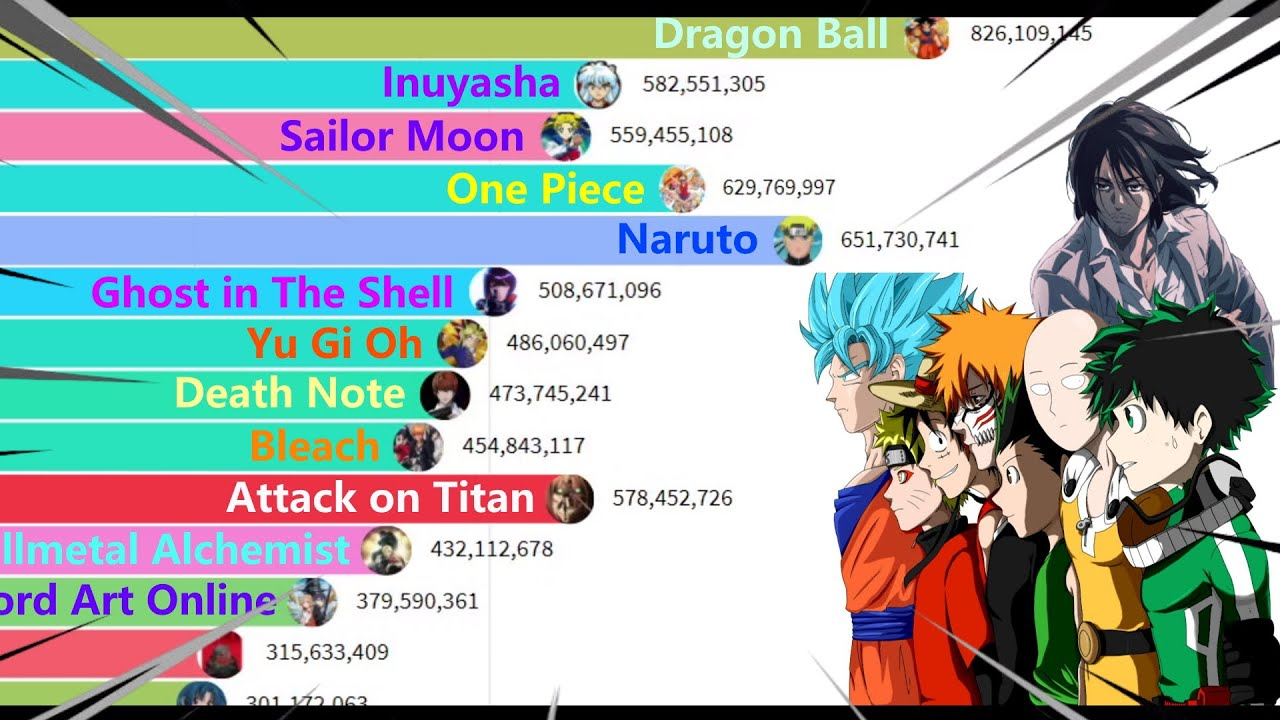

In [35]:
# First, get the top 20 anime based on the 'popularity' column
anime_top_df = anime_df.sort_values('popularity').head(20)

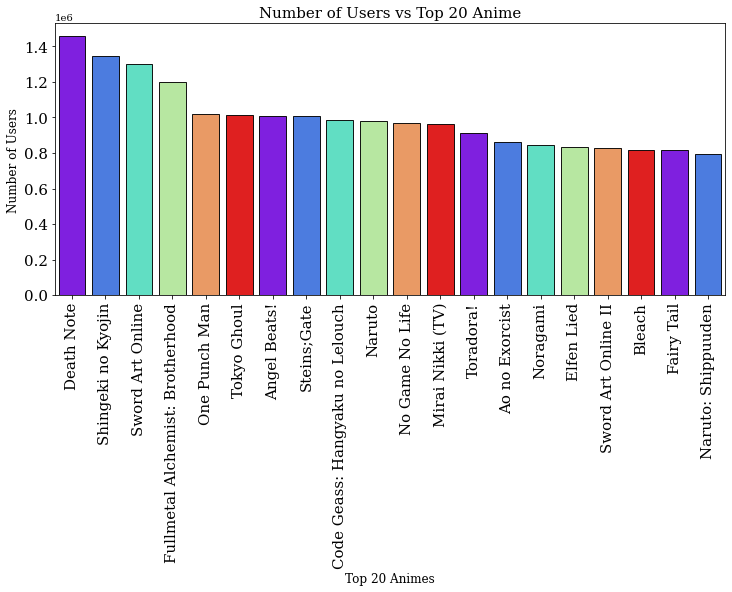

In [36]:
plt.rcParams['figure.figsize']=(12,5)

colors = cm.rainbow([0, .15, .4, .6, .8, 1])

sns.barplot(x="title", y="members", data=anime_top_df, palette = colors, linewidth=.9, edgecolor = "black")
plt.title('Number of Users vs Top 20 Anime', fontsize=15 )
plt.ylabel('Number of Users', fontsize=12)
plt.xlabel('Top 20 Animes', fontsize=12)
plt.xticks(rotation = 90)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

As of the publishing of this data set, it appears that the top 10 most added anime have around 1 million users interested or more.

### 1.5: Understanding the Userbase
Let's look at the userbase of MyAnimeList.

#### 1.5.1: Gender Distribution
First, we'll make a pie chart that shows the proporton of each gender (Male, Female, and Non-Binary).  Non-Binary was added as an option in 2016.

In [37]:
# First, get the propotion of each gender
user_gender_df = userlist_df[['gender', 'username']].groupby("gender").count().reset_index()
user_sum = len(userlist_df.index)
user_gender_df[['username']] = user_gender_df[['username']].div(user_sum).div(1/100)
user_gender_df = user_gender_df.rename(columns = {'username': 'Percent'})

In [38]:
# Next, process data to use for pie chart
data = user_gender_df['Percent'].to_numpy()
labels = user_gender_df['gender'].to_numpy()

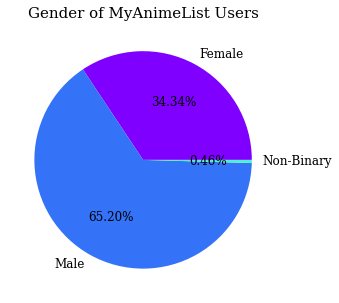

In [39]:
# Define Seaborn color palette to use
colors = sns.color_palette(colors)[0:5]

# Create pie chart
plt.title('Gender of MyAnimeList Users', fontsize = 15)
plt.pie(data, colors=colors ,labels=labels, autopct='%.2f%%', textprops={'fontsize': 12})
plt.show()

Clearly, most users are male (65.20%).  34.34% of users identify as female, and only 0.46% identify as non-binary.

When it comes to clustering and potential marketing, this is something to kepe in mind.  If the majority of hard-core anime fans are men, marketing should cater towards them rather than women and non-binary people.


#### 1.5.2: Gender Breakdown with User Age
We will plot the number of members (y) against a given user age (x).

In [40]:
# First, convert columns to datetime
userlist_df['birth_date'] = pd.to_datetime(userlist_df['birth_date'])
userlist_df['join_date'] = pd.to_datetime(userlist_df['join_date'])

In [41]:
# Approx. date of web scraping
today = pd.to_datetime('5/10/2018')

In [42]:
# Find the age of each member and their account
def age(born):
  return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [ ]:
user_df = userlist_df[['gender']]
user_df['Member Age'] = userlist_df['birth_date'].apply(age)
user_df['Account Age'] = userlist_df['join_date'].apply(age)

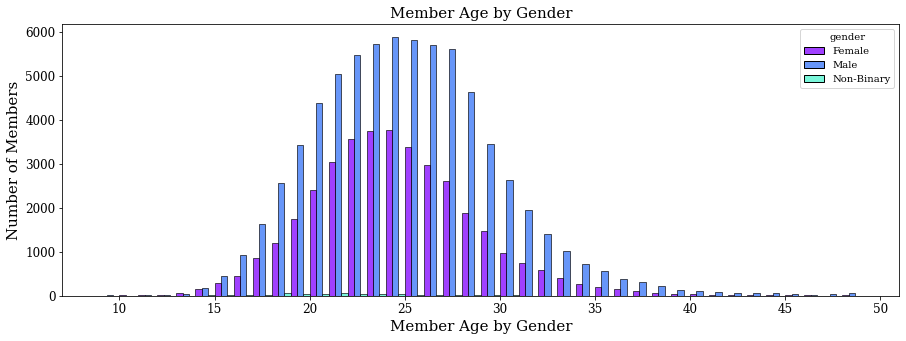

In [44]:
plt.rcParams['figure.figsize']=(15,5)
colors = sns.color_palette(colors)[0:3]

sns.histplot(data=user_df, x="Member Age", hue="gender", binwidth=1, multiple="dodge", palette = colors)
plt.title('Member Age by Gender', fontsize=15 )
plt.ylabel('Number of Members', fontsize=15)
plt.xlabel('Member Age by Gender', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

At any age, there are more males than females and more females than non-binary people on MyAnimeList.  All three distributions look approximately Gaussian, which makes sense because there are tens of thousands of entries for the male and female groups and hundreds for the non-binary group.

All three also appear to be slightly right skewed, with the max age being around 50 and the min age being around 10.  The median and mode appear to be around 25 years old for both male, female, and non-binary people.

#### 1.5.3: Gender Breakdown with Account Age
We will plot the number of members (y) against a given account age (x).

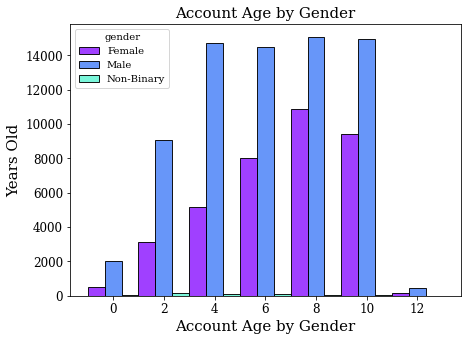

In [45]:
plt.rcParams['figure.figsize']=(7,5)

sns.histplot(data=user_df, x="Account Age", hue="gender", binwidth=2, multiple="dodge",  palette = colors, linewidth=.9, edgecolor = "black")
plt.title('Account Age by Gender', fontsize=15 )
plt.ylabel('Years Old', fontsize=15)
plt.xlabel('Account Age by Gender', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

MyAnimeList was created in 2004, so the maximum account age is 14.  There are no users scraped with accounts older than 12 yeras old.  This could be because the website initially did not have many users at all, or those users are no longer active, or a combination of both.

The graph shows an increase in non-binary user accounts peaking at 2 years old, which corresponds to how non-binary was introduced as an option 2 years before this dataset was collected.

For accounts owned by women, the account age peaks at 8 years old, with a steady decline in accounts older and younger.

For accounts owned by men, there are two peaks.  The number of accounts younger and older than those peaks also decrease.  This is likely because of how the data was collected.  Only users that were active in the watching challenge forums were colleccted.  The decreasing number of younger users could be due to the notion that more seasoned users participated in the challenges.  The decreasing number of older users could simply be because the website was not as popular, and therefore there are not many accounts that old in the first place.  Those users could have also "grown out" of watching anime after 10 years of being a fan.

#### 1.5.4: Summary of User Age and Gender
Let's take a look at the median of user age and account age for all genders.

In [46]:
# First, compute the age statistics
member_stats_df = user_df[["gender",	"Member Age"]].groupby('gender').median().reset_index().rename(columns = {"Member Age": "Age"})
member_stats_df['category'] = 'Member Age'

account_stats_df = user_df[["gender",	"Account Age"]].groupby('gender').median().reset_index().rename(columns = {"Account Age": "Age"})
account_stats_df['category'] = 'Account Age'

stats_df = pd.concat([member_stats_df, account_stats_df])

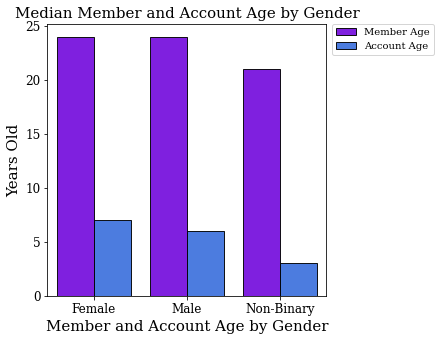

In [47]:
plt.rcParams['figure.figsize']=(5,5)

sns.barplot(x="gender", y="Age", hue = "category", data=stats_df, palette = colors, linewidth=.9, edgecolor = "black")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Median Member and Account Age by Gender', fontsize=15 )
plt.ylabel('Years Old', fontsize=15)
plt.xlabel('Member and Account Age by Gender', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The median age for males and females is around 24 years old, and the median age for non-binary people is around 22.

The median age for a female's account is 7 years, and the median age for a male's account is 6 years.  

Non-binary accounts have a median age of 3, despite non-binary being introduced as a gender option 2 years prior to data collection.  This implies that existing users switched their account settings to their correct gender after 2016, or perhaps users began their transition from a binary gender to non-binary after 2016.

The average age that a very passionate fan decides to further their interest in anime (i.e. by going on MyAnimeList / posting in forums) is around 16-19 years old.  This could suggest that marketing anime towards people in high school and college could be successful.

### 1.6: Understanding Genre Popularity
We aim to understand genres of top anime using both score and number of adds.  For the 500 anime with the highest score, we recorded the number of top anime in each genre.  This was repeated with the 500 anime that were most added.  The top 12 genres for each category were collected adn the number of shows were plotted against them in a bar graph.

In [48]:
num_anime = 500

# Preprocess anime_df to create score and popularity dfs
anime_simplified_df = anime_df[['score', 'members', 'genre']].dropna()

# Get top 500 anime based on score and number of members
anime_score_df = anime_simplified_df.sort_values('score', ascending=False).head(num_anime).set_index(['score', 'members'])
anime_pop_df = anime_simplified_df.sort_values('members', ascending=False).head(num_anime).set_index(['score', 'members'])

In [49]:
def explode_genre_by_feature(df, feature, col_name):
  anime_feature_exploded_df = df.apply(lambda x: x.str.split(',').explode()).reset_index()
  anime_feature_df = anime_feature_exploded_df.groupby('genre').count().sort_values('score', ascending=False).head(12)
  
  anime_feature_score_df = anime_feature_df[feature].to_frame()
  anime_feature_score_df['Popularity Metric'] = col_name
  anime_feature_score_df = anime_feature_score_df.rename(columns={feature: "Number of Anime"})
  anime_feature_score_df
  return anime_feature_score_df

In [50]:
anime_pop_df = explode_genre_by_feature(anime_pop_df, 'members', 'Most Members')
anime_score_df = explode_genre_by_feature(anime_score_df, 'score', 'Highest Score')

anime_pop_score_df = pd.concat([anime_pop_df, anime_score_df])
anime_pop_score_df = anime_pop_score_df.sort_values('Number of Anime', ascending=False).reset_index()

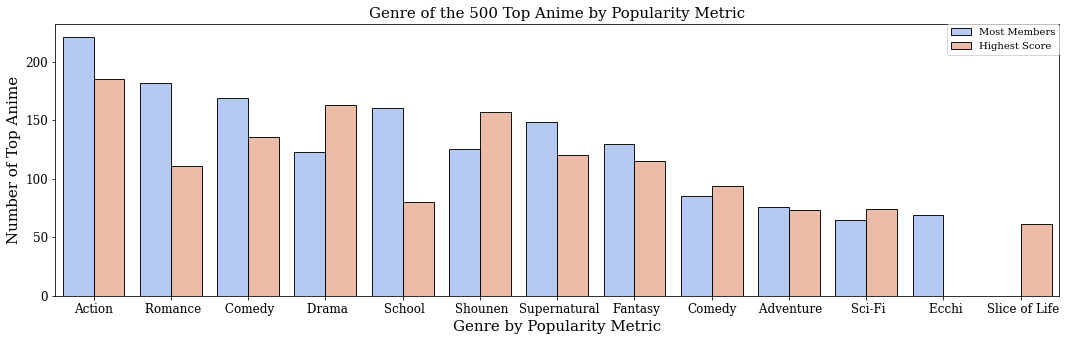

In [51]:
plt.rcParams['figure.figsize']=(18,5)

sns.barplot(x="genre", y="Number of Anime", hue="Popularity Metric", data=anime_pop_score_df, palette = 'coolwarm', linewidth=.9, edgecolor = "black")

plt.title('Genre of the ' + str(num_anime) + ' Top Anime by Popularity Metric', fontsize=15)
plt.ylabel('Number of Top Anime', fontsize=15)
plt.xlabel('Genre by Popularity Metric', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', borderaxespad=0);

For both metrics, the first 11 genres were the same.  The 12th top anime by number of adds was "Ecchi," which describes a genre categorized by playful sexuality.  The 12th top anime by score was "Slice of Life," a genre showing scenes from everyday life.

The top anime genres were Action, Romance, Comedy, and Drama, in that order.  Some genres tend to be more popular but less highly ranked, such as Action and Romance.  This indicates that people enjoy watching them, but they are not necessarily anime where people tend to score them highly.  On the other hand, some anime such as Drama and Shounen were more highly scored, but people don't tend to watch them as much.

### 1.7: Understanding Location
Our last feature to explore is location.  Location initially was user-entered, leading to amusing but unusable locations such as "hell" and "Unicornland, USA."  We were able to find a dataset including the locations after they were cleaned by Alejandro Agustin on Kaggle, who cleaned it by passing it through Nominatim service of OSM.

#### 1.7.1: What countries have the greatest number of users on MyAnimeList?
We graphed a bar plot of the number of users from the top 10 countries.

In [52]:
# Clean, standardize locations
location_groupby_df = location_df.groupby('country').count().reset_index().sort_values('country_code', ascending = False).head(10)
location_groupby_df = location_groupby_df.replace({"Brasil": "Brazil", "RP": "Phillipines", "РФ": "Russia", "Deutschland": "Germany", "Nederland": "Netherlands"})

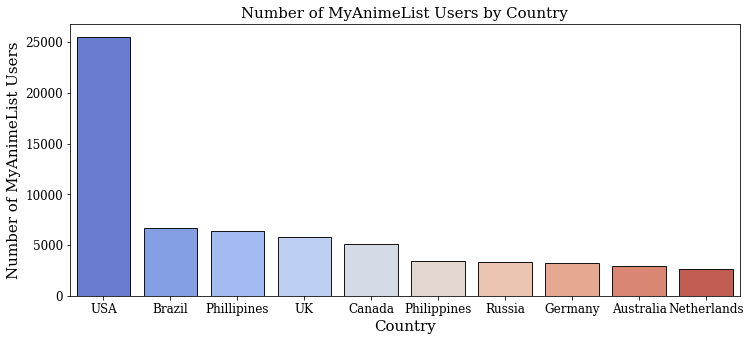

In [53]:
plt.rcParams['figure.figsize']=(12,5)

sns.barplot(x = 'country', y = 'country_code', data = location_groupby_df, palette = 'coolwarm', linewidth=.9, edgecolor = "black")

plt.title('Number of MyAnimeList Users by Country', fontsize=15)
plt.ylabel('Number of MyAnimeList Users', fontsize=15)
plt.xlabel('Country', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Clearly, the US exceeds other countries 5-fold.  Japan, the country of origin for most anime, ranks as number 13.  There seems to be an overrepresentation of English-speaking countries on this list, with 4/10 as primarily English-speaking countries.  This may be because of the difficulty of finding subtitled anime in other languages, which limits the popularity of anime in general for non-English, non-Japanese speakers.  This may suggest that marketing specifically to English-speakerswould be more successful, at least while anime subtitled in non-English languages are still rare.

We have a very skewed dataset in terms of location.  In the future, if more analysis is done, it may be a good idea to oversample all non-US countries to get a more balanced dataset.

#### 1.7.2: Demographic differences between the 5 most popular countries

For easier visualization, everything is normalized to the US values for number of anime in list, number of days watched, average score, and percent female of users from that country.



In [54]:
# Find top 5 countries
location_top_df = location_df.groupby('country').count().reset_index().sort_values('country_code', ascending = False).head(5)


In [55]:
# Compute user location and information
user_loc_df = pd.merge(location_df,userlist_df,on='user_id')
user_loc_df = pd.merge(myanimelist_count_df_total.reset_index(),user_loc_df,on='username')
user_loc_df = user_loc_df[user_loc_df['country'].notna()]
user_loc_df = user_loc_df[user_loc_df['birth_date'].notna()]
user_loc_df = user_loc_df.rename(columns = {'Number of Animes Listed': 'number_listed'})

In [56]:
user_stats_df = user_loc_df[['country_code', 'country', 'gender', 'birth_date', 'join_date', 'number_listed', 'user_days_spent_watching', 'stats_mean_score']]

# Compute mean user stats of each country
user_stats_df = user_stats_df.groupby('country').mean().reset_index()

# Compute female stats of each country
user_stats_df_female = user_loc_df[user_loc_df['gender'] == 'Female'].groupby('country').count()[['gender']]
user_stats_df_female['gender'] = user_stats_df_female['gender'].astype(int)
user_stats_df_all = user_loc_df.groupby('country').count()[['gender']]
user_stats_df_all['gender'] = user_stats_df_all['gender'].astype(int)
user_stats_df_all['percent_female']  =user_stats_df_female/user_stats_df_all

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [57]:
# Merge all information
user_stats_df = pd.merge(user_stats_df,user_stats_df_all['percent_female'],on='country')
user_stats_df = pd.merge(user_stats_df,location_top_df[['country']],on='country')
user_stats_df['percent_female'] = user_stats_df['percent_female'].fillna(0)
user_stats_df.loc[:,'number_listed':] = user_stats_df.loc[:,'number_listed':].div(user_stats_df.iloc[-1]['number_listed':])
user_stats_df = user_stats_df.rename(columns = {'number_listed': 'Normalized Number of Animes in List', "user_days_spent_watching": "Normalized Number of Days Spent Watching", "stats_mean_score": "Normalized Score Mean", "percent_female": "Normalized Percent Female"})
user_stats_df

country Normalized Number of Animes in List  \
0  Brasil                             1.14028   
1  Canada                            1.115517   
2      RP                             1.17394   
3      UK                            0.971576   
4     USA                                 1.0   

  Normalized Number of Days Spent Watching Normalized Score Mean  \
0                                 1.246303              0.987679   
1                                 1.129966              0.982371   
2                                 1.216932              0.967725   
3                                 0.965778              0.989329   
4                                      1.0                   1.0   

  Normalized Percent Female  
0                  0.844349  
1                  0.977218  
2                  1.428759  
3                  1.031567  
4                       1.0

From this table, it can be seen that Brazil, Cananda, and the Phillipines all seem to have more enthusiastic fans than the US, with each of them having the average anime list 11-17% longer than that in the US, whereas the average anime list in the UK tend to be shorter. 

A similar trend is seen in number of days spent watching. All four countries have lower average scores than the US. The UK and the Phillipines have a larger proportion of female users, whereas Brazil and Canada have a smaller proportion than the US. Knowing some of these differences could be helpful in further analysis, though we will not do it at this time. 

## 2: Data Manipulation For Clustering
In order to proceed with modeling, we will need to do some data manipulation. We want to get each user's average rating for the top 3 genres of anime we discovered in EDA, which are Action, Romance and Comedy. We have chosen to do this will spark SQL to enhance readability and runability. 

First, we define a helper function to create an sdf for the different genre averages.  For each user, we find their average romance, comedy, and action score and the number watched.  This function can be purposed for any genre, though.

In [58]:
def make_genre_avgs_sdf(genre_str):
  lower_genre_str = genre_str.lower()
  query = f"""
    SELECT r.username, avg(r.my_score) as avg_{lower_genre_str}_score, count(r.my_score) as num_{lower_genre_str}_watched
    FROM myanimelist r JOIN anime a ON a.anime_id = r.anime_id
    WHERE a.genre LIKE '{genre_str}'
    GROUP BY r.username
    ORDER BY avg(r.my_score) DESC """
  new_sdf = spark.sql(query)
  return new_sdf

In [59]:
# create sdfs with users and their action, romance and comedy average scores
action_sdf = make_genre_avgs_sdf('Action')
romance_sdf = make_genre_avgs_sdf('Romance')
comedy_sdf = make_genre_avgs_sdf('Comedy')
drama_sdf = make_genre_avgs_sdf('Drama')
shounen_sdf = make_genre_avgs_sdf('Shounen')

In [60]:
action_sdf.createOrReplaceTempView("action")
romance_sdf.createOrReplaceTempView("romance")
comedy_sdf.createOrReplaceTempView("comedy")
drama_sdf.createOrReplaceTempView("drama")

We next define a helper function to join the genre average tables on the user sdf, for 2 and 3 genres.  Note that these helper functions can be passed any genre.

In [61]:
def add_genre_avgs_2col(genre_str1, genre_str2):
  query = f"""
    SELECT u.username, u.user_watching, u.user_completed, u.user_onhold, u.user_dropped, u.user_plantowatch, u.user_days_spent_watching, u.gender, u.birth_date, u.join_date, u.last_online, u.stats_mean_score, u.stats_rewatched, u.stats_episodes,
    avg_{genre_str1}_score, num_{genre_str1}_watched, avg_{genre_str2}_score, num_{genre_str2}_watched
    FROM userlist u 
    JOIN {genre_str1} g1 ON g1.username=u.username
    JOIN {genre_str2} g2 ON g2.username=u.username
  """
  return_sdf = spark.sql(query)
  return return_sdf

In [62]:
def add_genre_avgs_3col(genre_str1, genre_str2, genre_str3):
  query = f"""
    SELECT u.username, u.user_watching, u.user_completed, u.user_onhold, u.user_dropped, u.user_plantowatch, u.user_days_spent_watching, u.gender, u.birth_date, u.join_date, u.last_online, u.stats_mean_score, u.stats_rewatched, u.stats_episodes,
    avg_{genre_str1}_score, num_{genre_str1}_watched, avg_{genre_str2}_score, num_{genre_str2}_watched, avg_{genre_str3}_score, num_{genre_str3}_watched
    FROM userlist u INNER JOIN {genre_str1} g1 ON g1.username=u.username
    INNER JOIN {genre_str2} g2 ON g2.username=u.username
    INNER JOIN {genre_str3} g3 ON g3.username=u.username
  """
  return_sdf = spark.sql(query)
  return return_sdf

In [63]:
userlist_with_genre_sdf = add_genre_avgs_2col('comedy', 'action')

In [64]:
userlist_with_3genre_sdf = add_genre_avgs_3col('romance', 'action', 'comedy')

In [65]:
userlist_with_genre_df = userlist_with_genre_sdf.toPandas()

In [66]:
userlist_with_3genre_df = userlist_with_3genre_sdf.toPandas()

In [67]:
# Type conversion
userlist_with_genre_df['birth_date'] = pd.to_datetime(userlist_with_genre_df['birth_date'], errors='coerce')
userlist_with_genre_df['join_date'] = pd.to_datetime(userlist_with_genre_df['join_date'])
userlist_with_genre_df['last_online'] = pd.to_datetime(userlist_with_genre_df['last_online'])
userlist_with_genre_df['num_gender'] = userlist_with_genre_df['gender'].apply(lambda x: 0 if 'Male' else 1)

In [68]:
# Bug handling
userlist_with_genre_df = userlist_with_genre_df[userlist_with_genre_df['stats_mean_score'] != '2018-01-15 23:40:53']
userlist_with_genre_df = userlist_with_genre_df.dropna(axis=0, subset=['stats_episodes'])

# Using previously defined today and age()
userlist_with_genre_df['member_age'] = userlist_with_genre_df['birth_date'].apply(age)
userlist_with_genre_df['account_age'] = userlist_with_genre_df['join_date'].apply(age)

userlist_with_genre_df = userlist_with_genre_df.astype({"user_watching":"int"})
userlist_with_genre_df = userlist_with_genre_df.astype({"user_completed":"int"})
userlist_with_genre_df = userlist_with_genre_df.astype({"user_onhold":"int"})
userlist_with_genre_df = userlist_with_genre_df.astype({"user_dropped":"int"})
userlist_with_genre_df = userlist_with_genre_df.astype({"user_plantowatch":"int"})
userlist_with_genre_df = userlist_with_genre_df.astype({"user_days_spent_watching":"float"})
userlist_with_genre_df = userlist_with_genre_df.astype({"stats_mean_score":"float"})
userlist_with_genre_df = userlist_with_genre_df.astype({"stats_episodes":"int"})


userlist_with_genre_df.head()

username  user_watching  user_completed  user_onhold  user_dropped  \
0       Drewge              6             268           20            39   
1    Miru-SAMA             29             108           10             8   
2  soccerjchen             10             107            2             4   
3   Mystogan03             41             592            0             0   
4         Hina              6             188           18            12   

   user_plantowatch  user_days_spent_watching  gender birth_date  join_date  \
0                13                 94.160069    Male 1990-10-18 2009-10-11   
1                89                 56.927083  Female 1992-11-01 2009-04-14   
2                11                 44.874306    Male 1988-03-24 2008-08-29   
3                77                141.813692    Male 1999-03-03 2015-06-14   
4                10                 26.336806  Female 1993-11-02 2010-12-22   

   ... stats_mean_score  stats_rewatched stats_episodes  avg_comedy_score  \
0  ...             8.40             36.0           5738          4.000000   
1  ...             7.67              7.0           3418          0.000000   
2  ...             7.04              0.0           2623          7.000000   
3  ...             7.39              7.0           8751          7.666667   
4  ...             7.01              2.0           2081          0.500000   

   num_comedy_watched  avg_action_score  num_action_watched  num_gender  \
0                   1              8.00                   1           0   
1                   3              0.00                   1           0   
2                   1              7.00                   1           0   
3                   6              6.75                   4           0   
4                   2              5.00                   2           0   

   member_age  account_age  
0          27            8  
1          25            9  
2          30            9  
3          19            2  
4          24            7  

[5 rows x 21 columns]

As can be observed above, we now have a userlist_with_genre_df that agglomerates the data about users genre habits and genre tastes. We also have cleaned it up to get useful metrics such as age (rather than birthday) and encoding for gender. 

We will proceed to do multiple clustering techniques to gather insight on these features. 

## 3: K-Means Clustering

In order to understand users better, and build a rudimentary recommendation system, we will build different clustering models.

Our hypothesis is that the clusters will be best informed my genre habits. Meaning, the features we choose to cluster on are going to be the average genre scores by user. 

For example: 

*   if Carolyn 👩🏼  has an average score of 10 for romance anime and 6.2 for action (a hopeless romantic)
*   and Hannah 👧🏻  has an average score of 9.8 for action anime and 4 for romance (she loves a good fight scene)
*   and Maya 👩🏽  has 3 for each (a picky critic!)
*   and Prof. Ives 🧑🏻  is a hopeless romantic like Carly (10 and 5)

We hypothesize that above other metrics in our data, such as age or gender, the genre tastes will inform meaningful clusters.

#### 3.1: Finding Initial Guiding Features
To start off, we will create pair plots to find initial features to guide our k-means clusters.

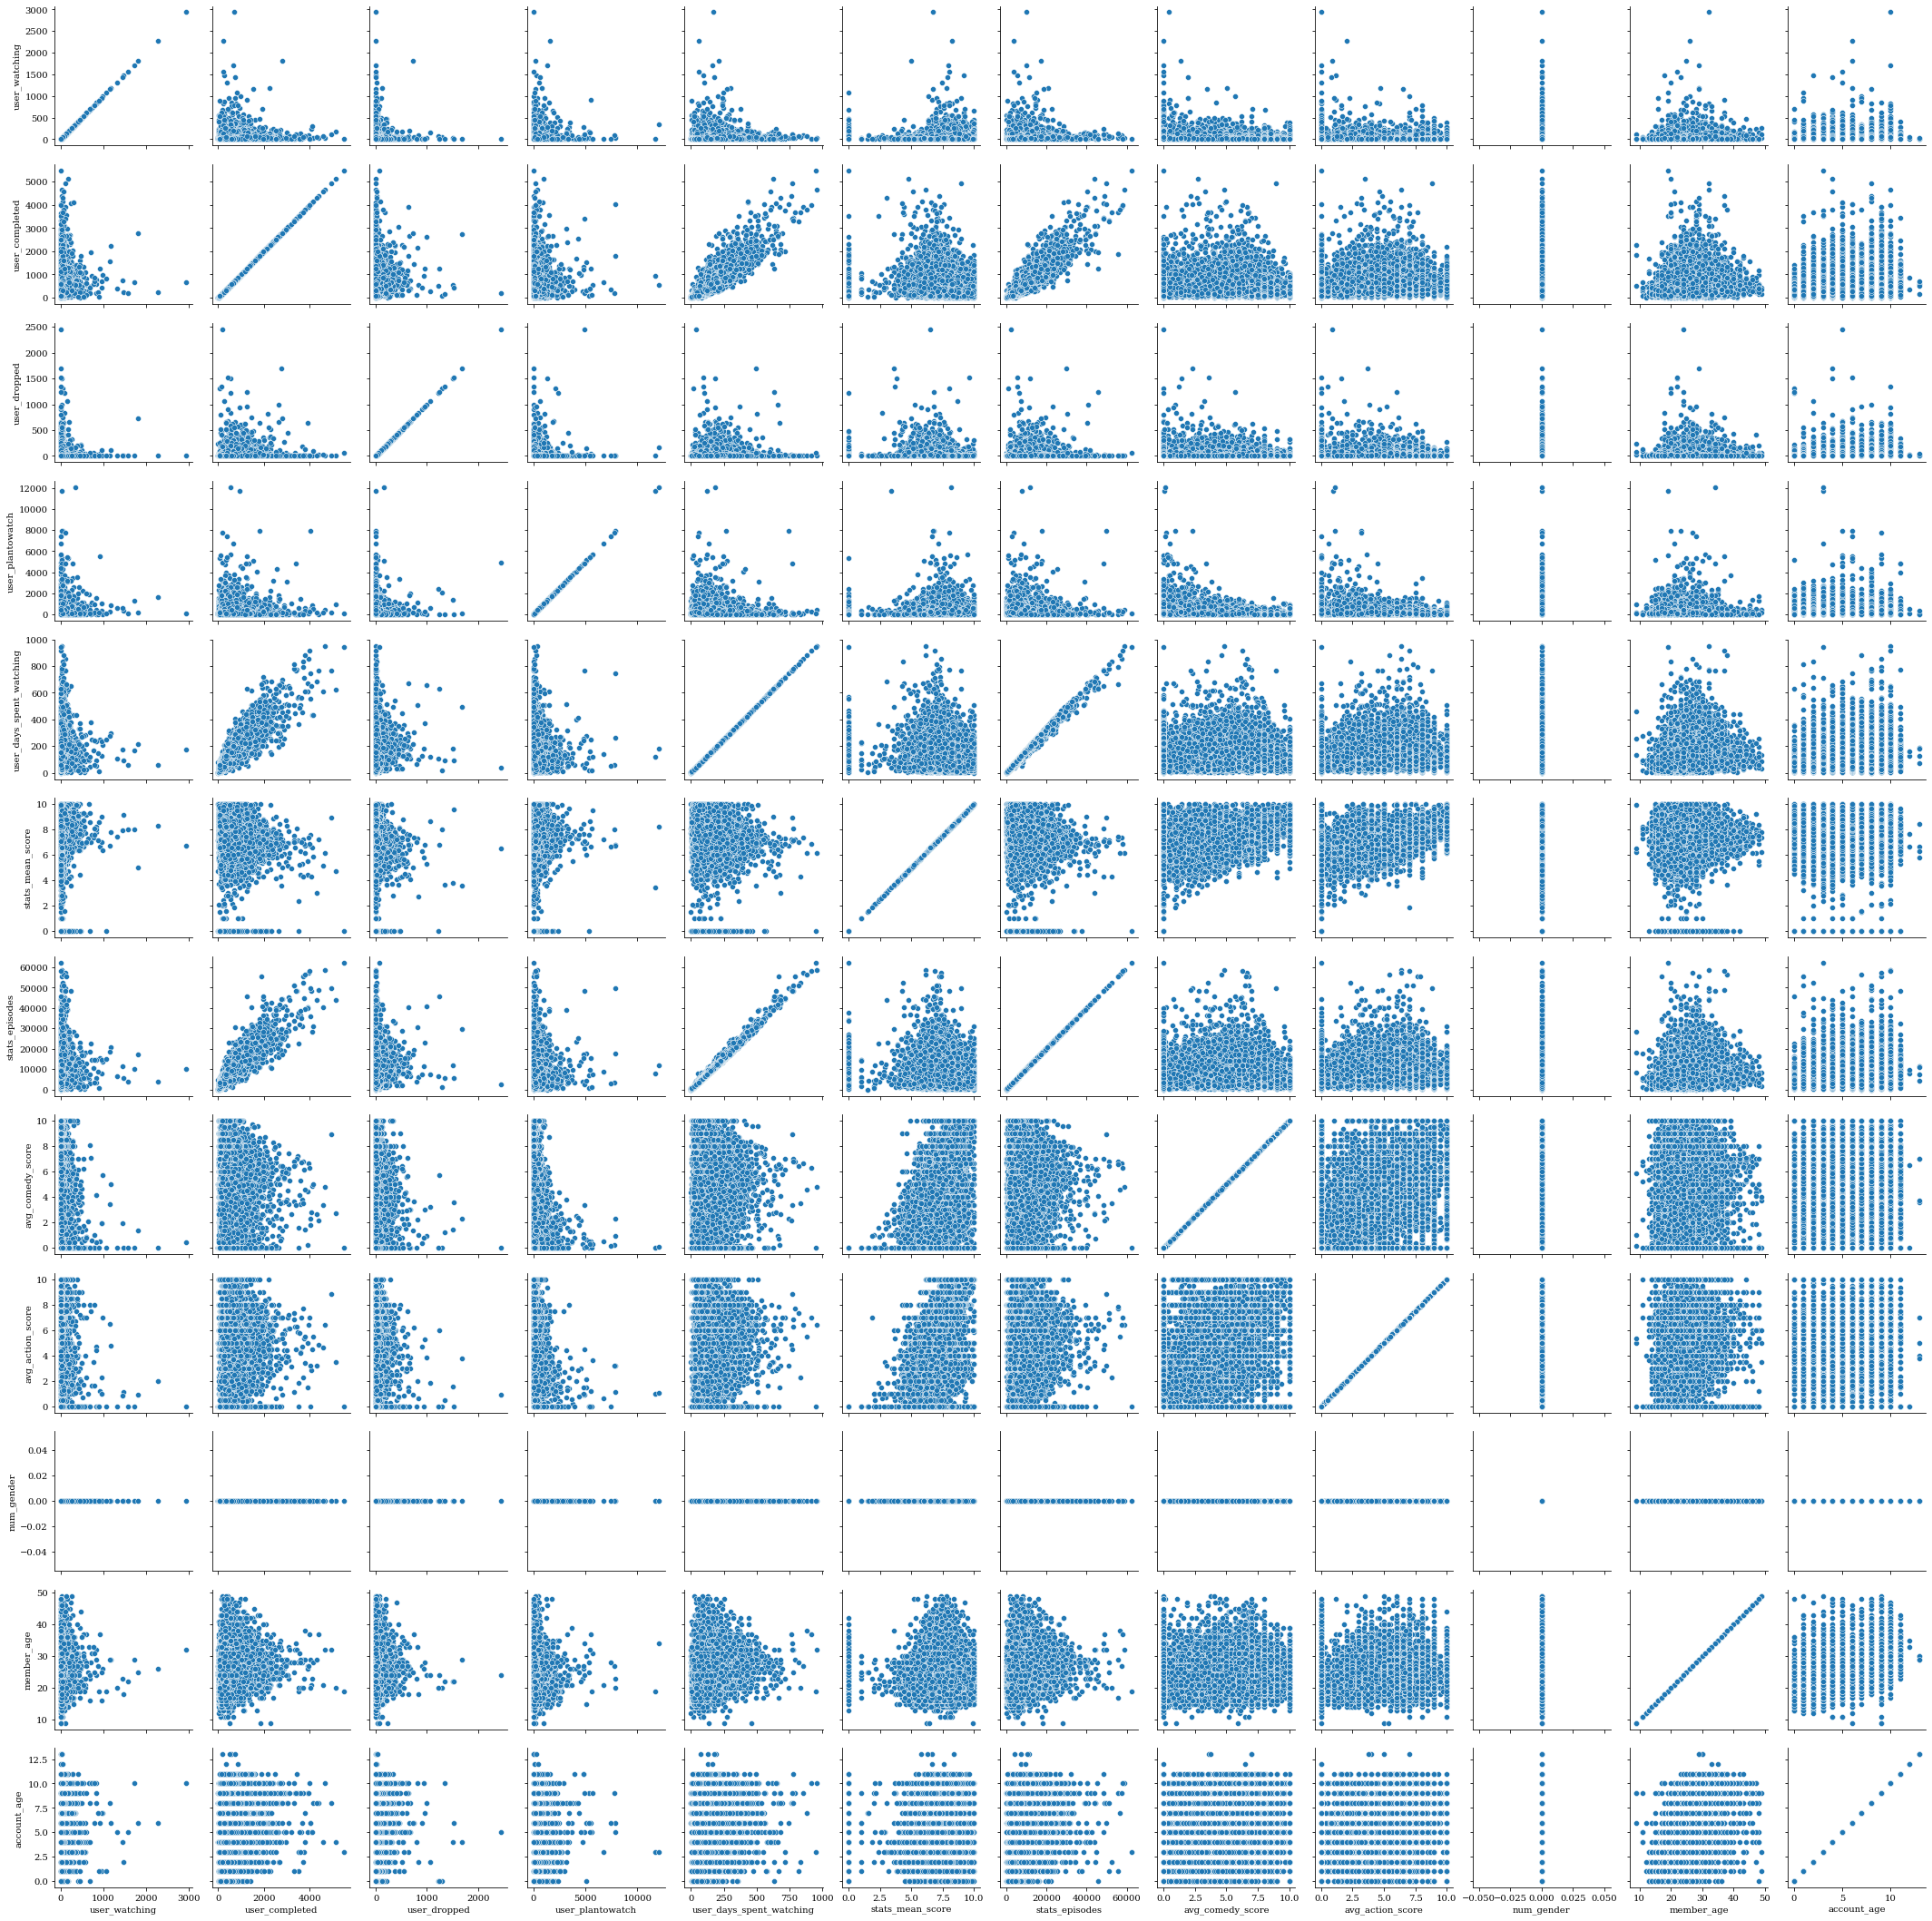

In [69]:
corr_data = sns.PairGrid(userlist_with_genre_df.drop(columns=['join_date', 'birth_date', 'last_online', 'user_onhold', 'gender', 'last_online', 'num_comedy_watched', 'num_action_watched']))
corr_data.map(sns.scatterplot);

From the above pair plot, as a starting point we will cluster based on a user's days_spent_watching and mean_score. This is an interesting starting point because the graph is not too disperate nor is it too concentrated.

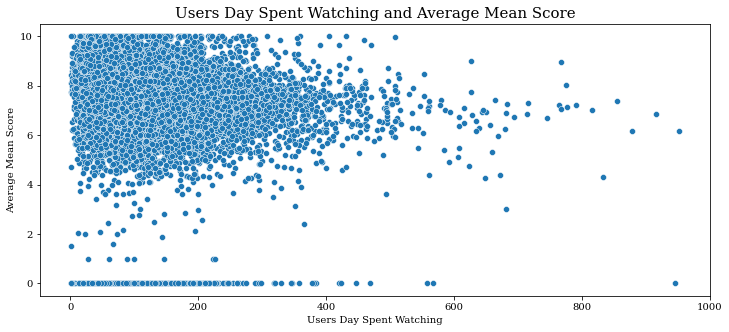

In [70]:
ax = sns.scatterplot(data=userlist_with_genre_df, x="user_days_spent_watching", y="stats_mean_score")
ax.set_xlabel('Users Day Spent Watching')
ax.set_ylabel('Average Mean Score')
ax.set_title('Users Day Spent Watching and Average Mean Score', fontsize = 15);

### 3.2: Clustering based on days spent watching and average mean score

#### 3.2.1: 2 Clusters

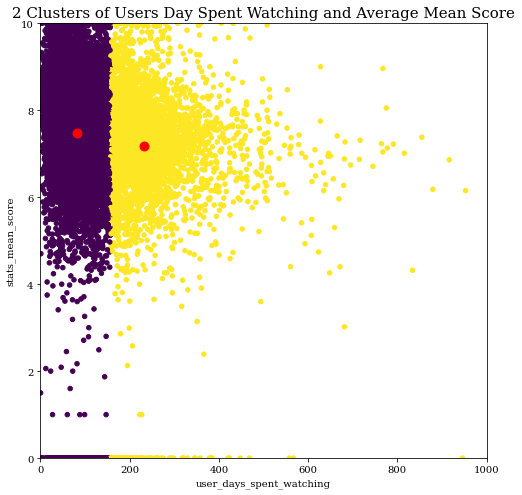

In [71]:
# First, extract the features that we will use to guide the clusters
userlist_days_mean = userlist_with_genre_df[['user_days_spent_watching', 'stats_mean_score']]

features = userlist_days_mean.values
kmeans_days_mean2 = KMeans(n_clusters=2)
clustered_days_mean2 = kmeans_days_mean2.fit(features)
userlist_with_genre_df['kmeans_days_mean2'] = kmeans_days_mean2.labels_

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(0, 1000)
plt.ylim(0, 10)
ax.set_xlabel('user_days_spent_watching')
ax.set_ylabel('stats_mean_score')
ax.set_title('2 Clusters of Users Day Spent Watching and Average Mean Score', fontsize = 15)

plt.scatter(userlist_with_genre_df['user_days_spent_watching'], userlist_with_genre_df['stats_mean_score'], c=userlist_with_genre_df['kmeans_days_mean2'], s=20, cmap='viridis')

# Plot the centroids
centroids = kmeans_days_mean2.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red');

From the above, we can see that user_days_spent_watching informs the clusters more than stats_mean_score, as the cluster that any point depends on is solely due to the number of days spent watching. Potentially if we increase the number of centroids, a cluster will form to encompass users below a certain mean score, like 5.  




#### 3.2.2: 4 Clusters
Now let's check it out with 4 clusters:

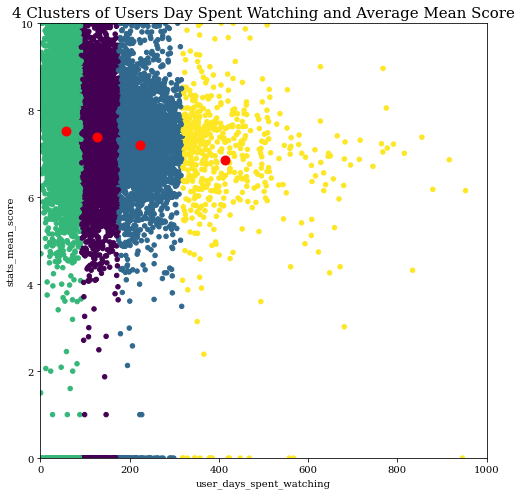

In [72]:
# First, extract the features that will be used to guide clustering
userlist_days_mean = userlist_with_genre_df[['user_days_spent_watching', 'stats_mean_score']]

features = userlist_days_mean.values
kmeans_days_mean4 = KMeans(n_clusters=4)
clustered_days_mean4 = kmeans_days_mean4.fit(features)
userlist_with_genre_df['kmeans_days_mean4'] = kmeans_days_mean4.labels_

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(0, 1000)
plt.ylim(0, 10)
ax.set_xlabel('user_days_spent_watching')
ax.set_ylabel('stats_mean_score')
ax.set_title('4 Clusters of Users Day Spent Watching and Average Mean Score', fontsize = 15)

plt.scatter(userlist_with_genre_df['user_days_spent_watching'], userlist_with_genre_df['stats_mean_score'], c=userlist_with_genre_df['kmeans_days_mean4'], s=20, cmap='viridis')

centroids = kmeans_days_mean4.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red');

With 4 clusters, the users are split up again into almost exactly vertical clusters. This shows the same conclusion as in the previous graph: stats_mean_score is not useful for clustering in this way. 


### 3.3: Clustering based on average comedy and action score

Now, lets get back to our hypothesis and analyze the following clusters from the pairplot, avg_comedy_score and avg_action_score

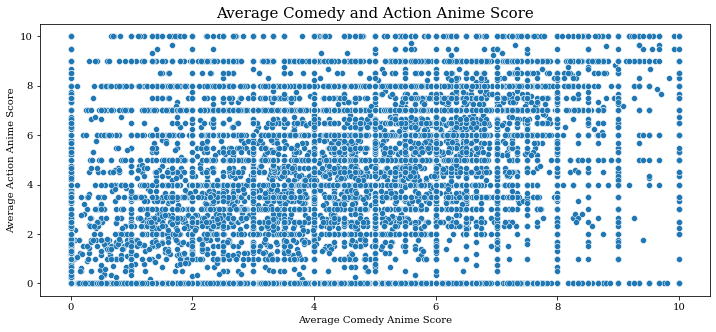

In [73]:
ax = sns.scatterplot(data=userlist_with_genre_df, x="avg_comedy_score", y="avg_action_score")
ax.set_xlabel('Average Comedy Anime Score')
ax.set_ylabel('Average Action Anime Score')
ax.set_title('Average Comedy and Action Anime Score', fontsize = 15);

#### 3.3.1: 2 Clusters

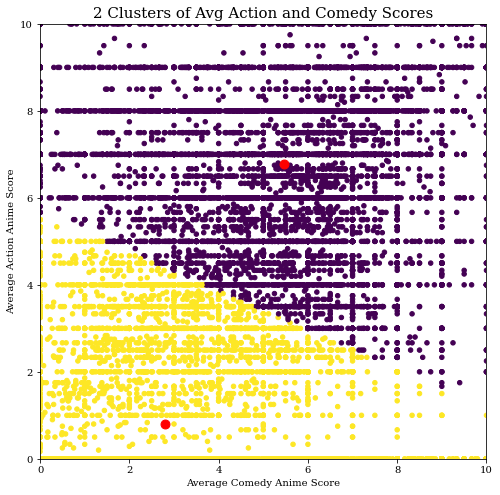

In [74]:
userlist_with_genre_simplified = userlist_with_genre_df[["avg_comedy_score", "avg_action_score"]]

features = userlist_with_genre_simplified.values
kmeans_genre2 = KMeans(n_clusters=2)
clustered_genre2 = kmeans_genre2.fit(features)
userlist_with_genre_df['kmeans_genre2'] = kmeans_genre2.labels_

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(0, 10)
plt.ylim(0, 10)
ax.set_xlabel('Average Comedy Anime Score')
ax.set_ylabel('Average Action Anime Score')
ax.set_title('2 Clusters of Avg Action and Comedy Scores', fontsize = 15)

plt.scatter(userlist_with_genre_df['avg_comedy_score'], userlist_with_genre_df['avg_action_score'], c=userlist_with_genre_df['kmeans_genre2'], s=20, cmap='viridis')

centroids = kmeans_genre2.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red');

Interestingly enough, it seems like the clusters are informed by a mix of comedy and action input. It seems that there is a group of users that doesn’t like action, but maybe likes comedy, and a group of users that likes action and maybe likes comedy. However, visually, the graph does not show clear clusters so this may not be completely true. 

Now we can analyze the correlation of user variables within the clusters

In [75]:
# helper function to draw a heatmap of a cluser, input is the column name of the cluster that has been stored in userlist
def draw_heatmap_for_cluster(cluster_col_name, cluster_num, clustering_title):
  this_df = userlist_with_genre_df[userlist_with_genre_df[cluster_col_name] == cluster_num]
  cluster_corr_data = (this_df.drop(columns=[cluster_col_name])).corr()
  norm = plt.Normalize(-1,1)
  ax = sns.heatmap(cluster_corr_data, cmap= 'RdBu', norm=norm)
  ax.set_title(f'Correlation heatmap of cluster {cluster_num} in {clustering_title}', fontsize = 15);

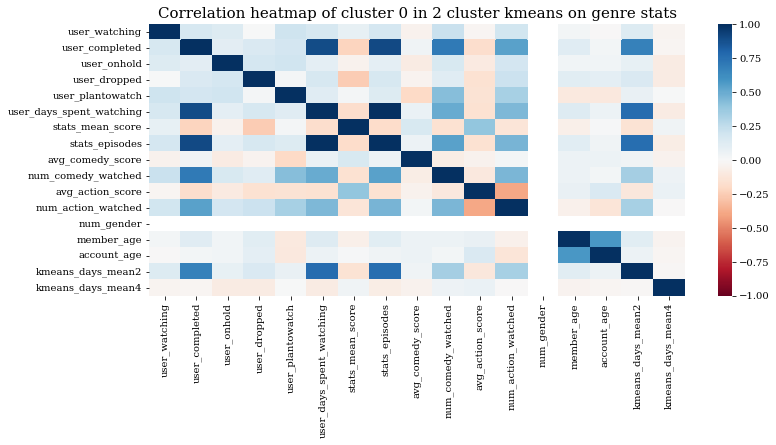

In [76]:
clustering_title = '2 cluster kmeans on genre stats'
draw_heatmap_for_cluster('kmeans_genre2', 0, clustering_title)

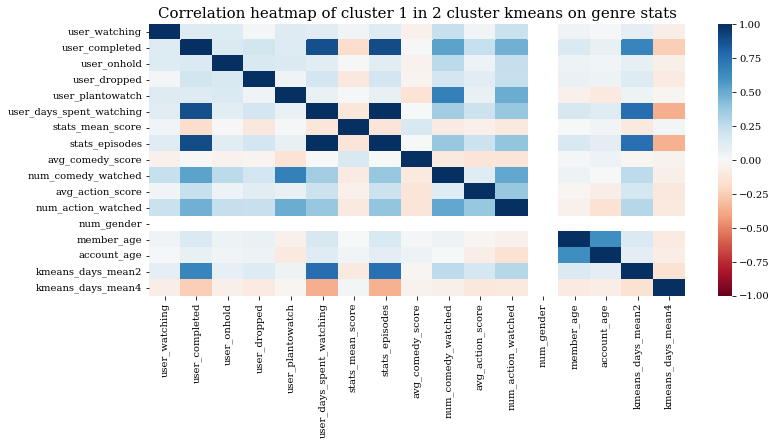

In [77]:
draw_heatmap_for_cluster('kmeans_genre2', 1, clustering_title)

Looking at the heat maps shows that most of the correlations are roughly similar. The column/row that is the most different is the average action score and the number of action animes watched. This indicates that the clustering is more dependent on the number and score of action animes watched than on comedy, which could be useful to keep in mind when we do further clustering, next lets try again using the Elbow Method.  

#### 3.3.2 Using Elbow Method to find Optimal K

For the next portion, we must figure out how many centroids we would like, we will thus deploy the Elbow method

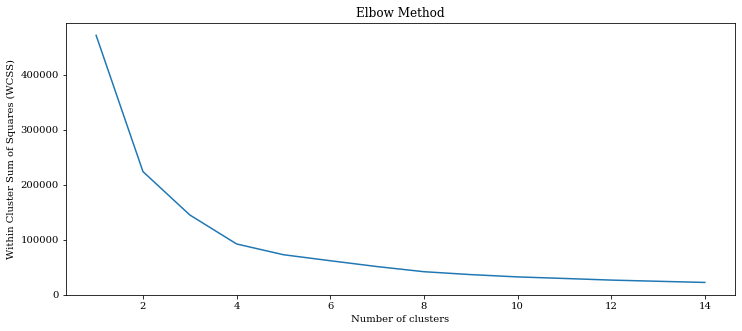

In [78]:
# elbow method
wcss = []
for i in range(1, 15):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',
                    max_iter = 300,
                    n_init = 10,
                    random_state = 0)
    model.fit(features)                              
    wcss.append(model.inertia_)
    
# Show Elbow plot
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      
plt.show()

From the graph above, we can observe that the tangent line hits and curves 4. This is where the plateau begins. We will thus proceed with 4 clusters. 

We will also graph the silhouette score in terms of clusters as well to see if we get the same ratification of clutering on 4.

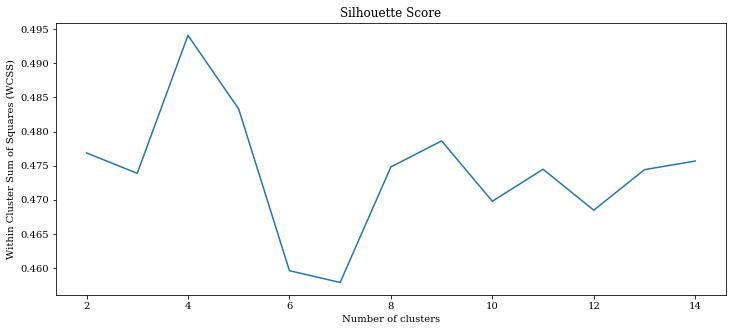

In [79]:
# silhouette score
wcss = []
for i in range(2, 15):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',
                    max_iter = 300,
                    n_init = 10,
                    random_state = 0)
    model.fit(features) 
    wcss.append(silhouette_score(features, model.labels_, metric='euclidean'))                             

# Show silhouette plot
plt.plot(range(2, 15), wcss)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      
plt.show()

We can see above that the silhouette score peaks at 4 clusters. We want the silhouette score to be as close to 1 as possible, thus this is further confirmation that we will use 4 clusters

#### 3.3.3 4 Clusters

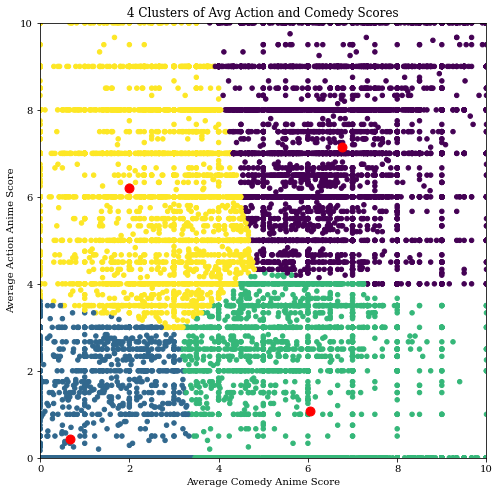

In [80]:
kmeans_genre4 = KMeans(n_clusters=4)
clustered_genre4 = kmeans_genre4.fit(features)
userlist_with_genre_df['kmeans_genre4'] = kmeans_genre4.labels_

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(0, 10)
plt.ylim(0, 10)
ax.set_xlabel('Average Comedy Anime Score')
ax.set_ylabel('Average Action Anime Score')
ax.set_title('4 Clusters of Avg Action and Comedy Scores')

plt.scatter(userlist_with_genre_df['avg_comedy_score'], userlist_with_genre_df['avg_action_score'], c=userlist_with_genre_df['kmeans_genre4'], s=20, cmap='viridis')

# 0 is bottom left , 1 is top right , 2 is bottom right, 3 is top left 
centroids = kmeans_genre4.cluster_centers_
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red');

The deliniation among clusters is intersting and distributed. Graphed out, the clusters don’t appear to be very distinct. This could be partly due to how the clusters are limited to globular shapes, but it could also be because there is not much predictive power based on these two variables alone. We will proceed to analyze the clusters nonetheless to understand their usefulness.

We will now try and characterize the clusters. 

*What does this say about our friends Carolyn, Hannah, Maya and Prof. Ives? 👩🏼👧🏻👩🏽🧑🏻*

We can see that Maya, the harsh critic, is in the bottom/left cluster. Carolyn and Prof. Ives are not only hopeless romantics but love a good knee slapper, so are likely in the top/right cluster. Hannah, as a lover of action, is definitely in the top/left or top/right cluster but we actually do not know her scores of comedy movies. 

Is there a way that we could analyse the top/left and top/right  clusters and try and figure out what OTHER metrics she most resembles. Is she similar to Carolyn and Prof. Ives' cluster? Or is she more similar to those in the top/left? Should we should recommend Gintama (the funniest anime) to her next? Or should we opt for just anther action. 

If we recommend Gintama and she loves it, she could end up a long time customer, watching both her comedy AND action anime on our platform. If she doesn't love it, we risk losing her as a customer all together.

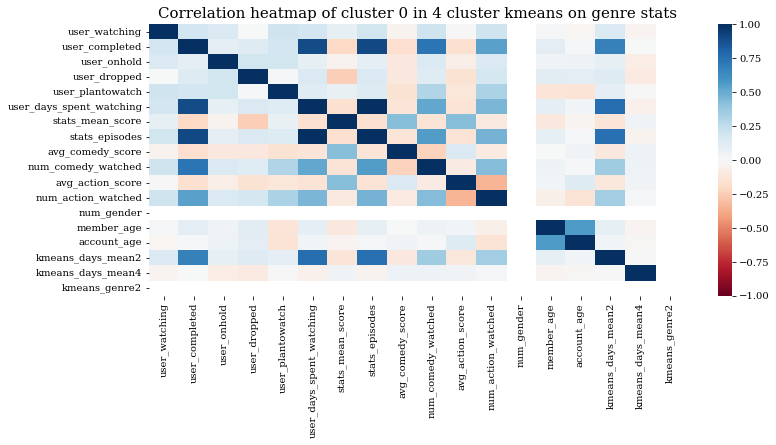

In [81]:
clustering_title = '4 cluster kmeans on genre stats'
draw_heatmap_for_cluster('kmeans_genre4', 0, clustering_title)

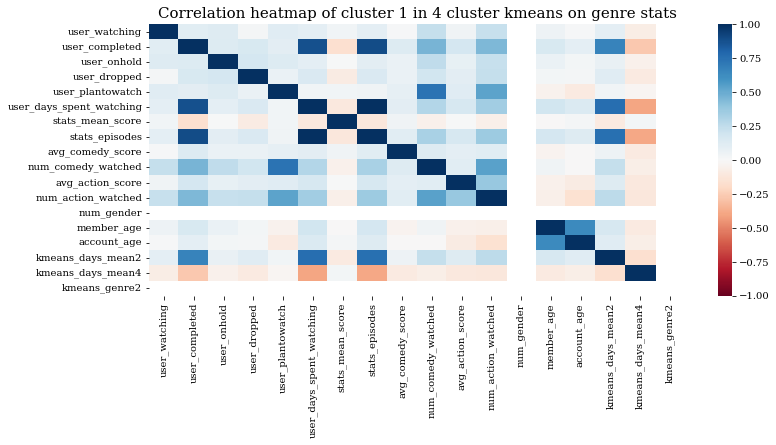

In [82]:
draw_heatmap_for_cluster('kmeans_genre4', 1, clustering_title)

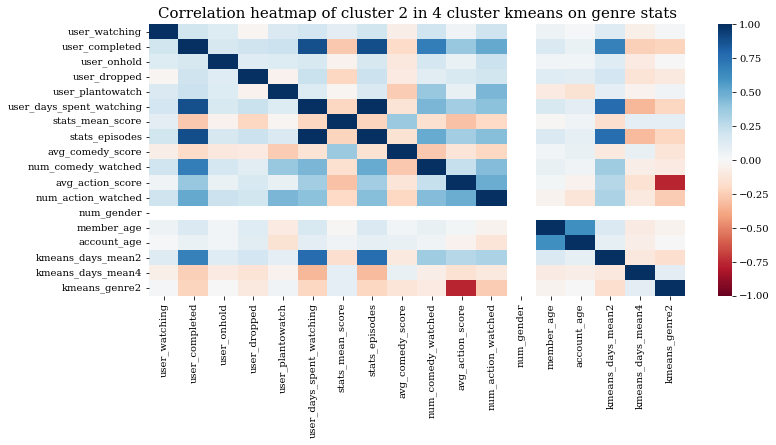

In [83]:
draw_heatmap_for_cluster('kmeans_genre4', 2, clustering_title)

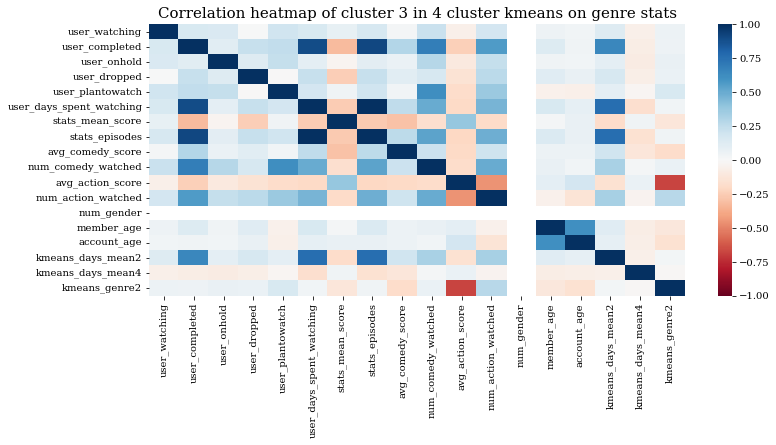

In [84]:
draw_heatmap_for_cluster('kmeans_genre4', 3, clustering_title)

The fourth and first graphs differ from the second and third mostly on average action score. Between the fourth and first graph, the main difference seems to be in the number of action anime watched. Second and third differ on number in plan to watch, average comedy score, and average action score, indicating that the clusters are split based on those three variables. This implies that these are likely the most important variables that differentiate users across clusters, but again, if the true clusters are not globular and if the true number of clusters is different from the number used in the K-means clustering. Let us evaluate these clusters and then use a different clustering method in order to further investigate if we can cluster based on the two most popular genres. 

Because clustering is an unsupervised learning method, it can be difficult to establish a good performance metric. We will proceed to try and evaluate the quality of our model. We will begin by  calculating the distoirtion for the 4 kmeans clusters. The  distortion function is the sum of distance for each point to its centroid. 

We used intertia earlier in the elbow method but will re-examine it

In [85]:
intertia = clustered_genre4.inertia_
print(f'The intertia for our genre model with 4 clusters is {intertia}')

The intertia for our genre model with 4 clusters is 92385.77773341873


It is clear that this intertia is very large. Yet, this was the intertia we concluded with from the elbow method so it is the most optimal for our model and its tradeoff. Potentially moving forward we would want to try and find ways to remove variance from our clusters.

Lets try silhouette:

In [86]:
silhouette = silhouette_score(features, kmeans_genre4.labels_, metric='euclidean')
print(f'The silhouette score for our genre model with 4 clusters is {silhouette}')

The silhouette score for our genre model with 4 clusters is 0.49407467224418566


Our silhouette score is above 0, thus we do not have anything to worry about in terms of faulty clusters, nonetheless we may want to try and improve this score to be closer to 1

## 4: Agglomerative Clustering
We will now explore a similar hypothesis with the agglomerative clustering method.

### 4.1: Clustering based on average romance and action score

In [87]:
# Create a dataframe with the average action and romance scores, set username as index
userlist_with_genre_df = add_genre_avgs_2col('romance', 'action').toPandas()

In [88]:
userlist_with_genre_simplified_df = userlist_with_genre_df[['username', 'avg_action_score', 'avg_romance_score']].set_index('username')
userlist_with_genre_simplified_df

avg_action_score  avg_romance_score
username                                             
Kanashimi_Jigoku          4.000000                3.0
Onizuka-kun               3.000000                0.0
Komirai                   0.000000                0.0
rioave88                  5.400000                8.5
isshuukan                 0.000000                4.0
...                            ...                ...
jGRite                    0.000000                0.0
PrinceKirameki            3.166667                5.0
Sad-chan                  0.000000                0.0
Arishiana                 6.000000               10.0
darkest_shadow            0.000000                0.0

[2464 rows x 2 columns]

In [89]:
# Create the euclidean distance matrix
index = userlist_with_genre_simplified_df.index.to_list()
row_dist_df = pd.DataFrame(squareform(pdist(userlist_with_genre_simplified_df, metric='euclidean')),
                           columns=index, index=index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


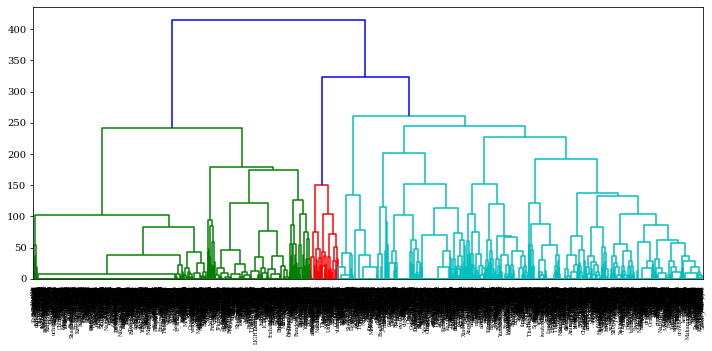

In [90]:
# Create the clusters and plot in a dendrogram
row_clusters = linkage(row_dist_df, method='complete')
plt.figure()
dn=hierarchy.dendrogram(row_clusters,labels=index)

In [ ]:
# Perform agglomerative clustering + find cluster labels
clusters = len(set(dn['color_list'])) - 1
model = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')
model.fit(row_dist_df)
labels = model.labels_
userlist_with_genre_df['agglomerative_cluster'] = labels

In [92]:
# Extract the users in each cluster and place into seaparte dataframes
cluster_0 = userlist_with_genre_df[userlist_with_genre_df['agglomerative_cluster'] == 0]
cluster_1 = userlist_with_genre_df[userlist_with_genre_df['agglomerative_cluster'] == 1]
cluster_2 = userlist_with_genre_df[userlist_with_genre_df['agglomerative_cluster'] == 2]

In [93]:
# Take out the average scores for the purpose of plotting
cluster_0_no_users = cluster_0[['avg_action_score', 'avg_romance_score']]
cluster_1_no_users = cluster_1[['avg_action_score', 'avg_romance_score']]
cluster_2_no_users = cluster_2[['avg_action_score', 'avg_romance_score']]

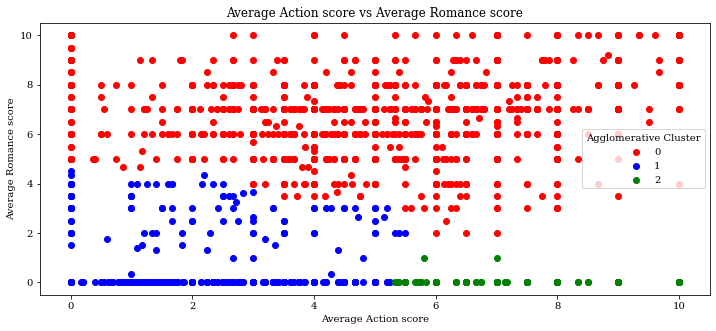

In [94]:
plt.scatter(x=cluster_0_no_users['avg_action_score'], y=cluster_0_no_users['avg_romance_score'], color='red', label='0')
plt.scatter(x=cluster_1_no_users['avg_action_score'], y=cluster_1_no_users['avg_romance_score'], color='blue', label='1')
plt.scatter(x=cluster_2_no_users['avg_action_score'], y=cluster_2_no_users['avg_romance_score'], color='green', label='2')
plt.xlabel('Average Action score')
plt.ylabel('Average Romance score')
plt.title('Average Action score vs Average Romance score')
plt.legend(title='Agglomerative Cluster')
plt.show()

Clusters are more informed by the average romance score.

For those who do not like romance anime, the clusters are informed by how much they enjoy action anime.

### 4.2: EDA on Found Clusters
Let's explore what might be similar between the users in each cluster.

#### 4.2.1: Cluster gender distribution

In [95]:
def create_pie_chart(df, category, title):
  category_df = df[[category, 'username']].groupby(category).count().reset_index()
  user_sum = len(df.index)
  category_df[['username']] = category_df[['username']].div(user_sum).div(1/100)
  category_df = category_df.rename(columns = {'username': 'Percent'})

  data = category_df['Percent'].to_numpy()
  labels = category_df[category].to_numpy()
  colors = sns.color_palette('pastel')[0:5]

  plt.title(title)
  plt.pie(data, labels=labels, colors=colors, autopct='%.2f%%')
  plt.show()
  data

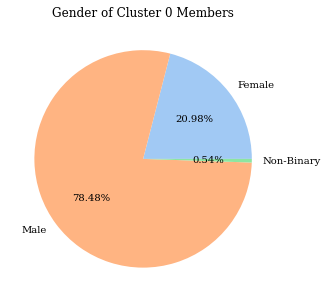

In [96]:
create_pie_chart(cluster_0, 'gender', 'Gender of Cluster 0 Members')

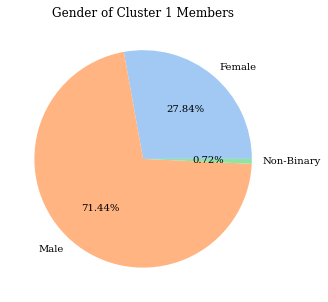

In [97]:
create_pie_chart(cluster_1, 'gender', 'Gender of Cluster 1 Members')

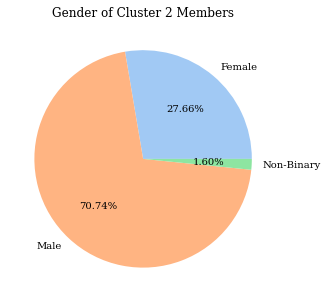

In [98]:
create_pie_chart(cluster_2, 'gender', 'Gender of Cluster 2 Members')

The gender distribution between clusters 1 and 2 are very similar.  Most notably, cluster 0 contains slightly more men.

#### 4.2.2: Cluster generation distribution
Let's see what the generational makeup is for the clusters.


*   Gen X: 1965 - 1981
*   Millennial: 1982 - 1996
*   Gen Z: 1996 - 2012

We do not include Gen Alpha because the youngest member of each cluster is still a Gen Z member.

In [99]:
def generation(born):
  if born < pd.to_datetime('1/1/1982'):
    return 'Gen X'
  elif born < pd.to_datetime('1/1/1997'):
    return 'Millenial'
  else:
    return 'Gen Z'

In [ ]:
cluster_0['birth_date'] = pd.to_datetime(cluster_0['birth_date'])
cluster_1['birth_date'] = pd.to_datetime(cluster_1['birth_date'])
cluster_2['birth_date'] = pd.to_datetime(cluster_2['birth_date'])

In [ ]:
cluster_0['generation'] = cluster_0['birth_date'].apply(generation)
cluster_1['generation'] = cluster_1['birth_date'].apply(generation)
cluster_2['generation'] = cluster_2['birth_date'].apply(generation)

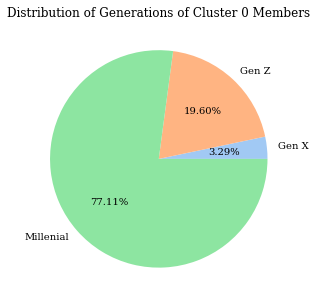

In [102]:
create_pie_chart(cluster_0, 'generation', 'Distribution of Generations of Cluster 0 Members')

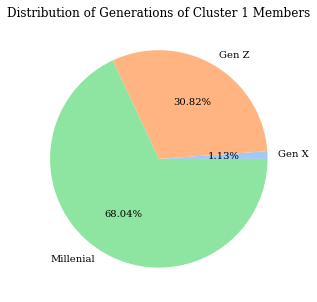

In [103]:
create_pie_chart(cluster_1, 'generation', 'Distribution of Generations of Cluster 1 Members')

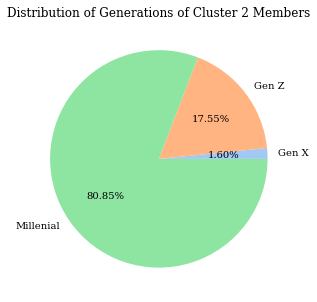

In [104]:
create_pie_chart(cluster_2, 'generation', 'Distribution of Generations of Cluster 2 Members')

Although millenials dominate all three clusters, almost 4 in 5 members of Cluster 2 are millenials.  On the other hand, Cluster 1 has significantly more Gen Z members than the other two.  This is interesting because Gen Z responds better to different social media marketing strategies than members of other generations.

#### 4.2.3 Finding other genres of interest
Having clusters of users isn't enough - we want to understand what new content to recommend them.

Imagine the following scenario: Crunchyroll wants to promote some new and original (as opposed to being adapted from a manga) anime to its targeted user groups.  What genres are these user groups interested in?  What new anime would they be more likely to watch?

In [105]:
# Find all original anime that started airing from 2018
anime_df_aired_from_2018 = anime_df[anime_df['aired_from_year'] == 2018]
anime_df_original_aired_from_2018 = anime_df_aired_from_2018[anime_df_aired_from_2018['source'] == 'Original']

In [106]:
interested_genre_df = anime_df_aired_from_2018[['anime_id', 'score', 'genre']].dropna()

In [107]:
# Remove anime classified as action and romance
interested_genre_df = interested_genre_df[~interested_genre_df['genre'].str.contains('Action')]
interested_genre_df = interested_genre_df[~interested_genre_df['genre'].str.contains('Romance')]

# Explode genre
interested_genre_df['genre'] = interested_genre_df['genre'].apply(lambda x: x.split(','))
interested_genre_df = interested_genre_df.explode(column='genre')
interested_genre_df['genre'] = interested_genre_df['genre'].astype('string')
interested_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 68 to 6663
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  304 non-null    int64  
 1   score     304 non-null    float64
 2   genre     304 non-null    string 
dtypes: float64(1), int64(1), string(1)
memory usage: 9.5 KB


For a given cluster, we'll find the top 10 genres of interest.  We do this by looking at the anime that each user plans to watch.  This indicates interest in what they want to view next rather than their viewing history.

In [108]:
# Find the top 10 genres of interest
def getGenreInterest(cluster_df, status):
  cluster_users = cluster_df[['username']]
  plan_to_watch_df = myanimelist_df[myanimelist_df['my_status'] == status]
  cluster_watched = cluster_users.merge(plan_to_watch_df[['anime_id', 'username']], on='username', how='inner')
  cluster_watched_info = cluster_watched.merge(interested_genre_df, on='anime_id')
  cluster_watched_info['genre'] = cluster_watched_info['genre'].apply(lambda x: x.strip())

  cluster_watched_info = cluster_watched_info[['username', 'score', 'genre']]

  cluster_by_genre = cluster_watched_info.groupby('genre').count().reset_index()
  cluster_by_genre = cluster_by_genre[['genre', 'username']].sort_values('username', ascending=False).head(10)

  return cluster_by_genre

In [109]:
def plotGenreInterest(cluster_by_genre, title):
  sns.barplot(x="genre", y='username', data=cluster_by_genre)
  plt.title(title)
  plt.xlabel('Genre')
  plt.xticks(rotation = 45)
  plt.ylabel('Number of instances in cluster')

In [110]:
cluster_0_by_genre = getGenreInterest(cluster_0, 6)

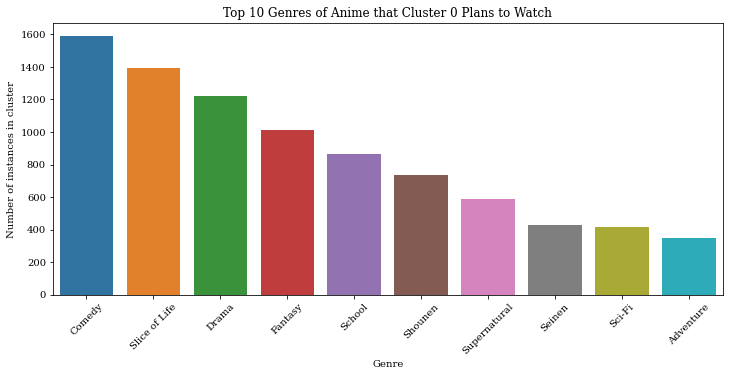

In [111]:
plotGenreInterest(cluster_0_by_genre, 'Top 10 Genres of Anime that Cluster 0 Plans to Watch')

In [112]:
cluster_1_by_genre = getGenreInterest(cluster_1, 6)

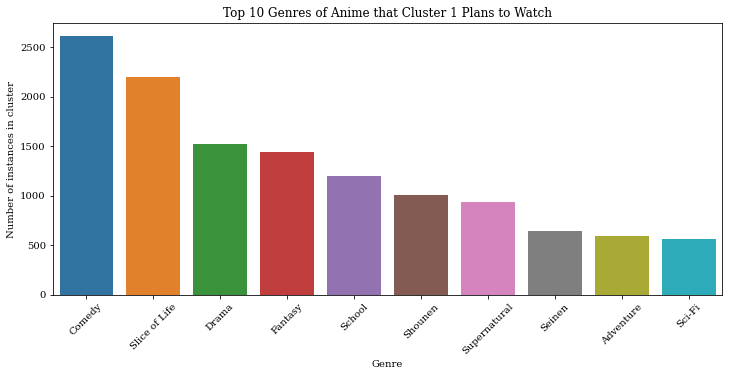

In [113]:
plotGenreInterest(cluster_1_by_genre, 'Top 10 Genres of Anime that Cluster 1 Plans to Watch')

In [114]:
cluster_2_by_genre = getGenreInterest(cluster_2, 6)

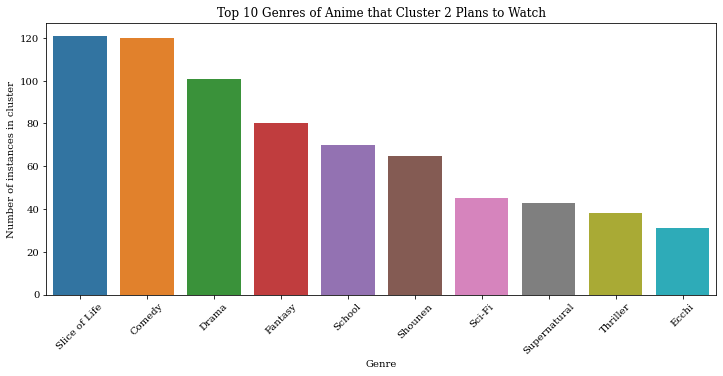

In [115]:
plotGenreInterest(cluster_2_by_genre, 'Top 10 Genres of Anime that Cluster 2 Plans to Watch')

This analysis yielded minimal conclusions.  Most people in the clusters plan to watch the same genres, and these genres are quite similar to the most popular genres that were shown in our initial EDA.

Still, Cluster 0 is more likely to be interested in Sci-Fi over Adventure, and the opposite is true for Cluster 1.

Cluster 2 seems to be more intersted in slice of life anime than members of the other clusters, and show more interest in the Thriller and Ecchi genres (these did not make the top 10 for the other clusters).

### 4.3: Agglomerative Cluster Analysis
Seeing as our cluster EDA did not give us as many answers as we wanted, let's evaluate the quality of the clusters formed using the Silhouette Coefficient.

1 indicates that the clusters are far away from each other and self-contained.
0 indicates that they clusters are overlapping.
-1 is the worst score possible.

In [116]:
silhouette_score(row_dist_df, labels)

0.5005109399796689

The silhouette score is around 0.5, halfway in between 0 and 1.  Since this is not a terrible score, one or more of the following is possible:


1.   The agglomerative clustering model overfits the data and does not speak to general trends in user groups.
2.   The average score that a user gives romance and action anime are correlated, but this does not have much to do with segmenting users into groups since these generes are very popular.



## 5: Conclusion

Overall, we are excited that we got to creatively tip our toes into understanding better how we would go about thinking about a recommendation system for anime:) Its the $1M problem!! 💰💰 👩🏼👧🏻👩🏽

We feel like we learned a lot about unsupervised learning and the difficulties and merits of clustering. Additionally we feel like we benefitted a lot from such open ended research and design.

As anime increases in popularity, recommendation systems like this will be imperative to getting more people on board. 

### 5.1: EDA
EDA revealed much about the demographics and habits of My Anime List users. The average user watches about 5 animes at a time, has finished over a hundred, and plans to watch around 25, though a very small percentage of users add hundreds or thousands more to each category. Most users rarely dropped anime or put them on hold.

Most anime are only added by several hundred users, even though their scores tend to be average to high. The most popular anime scores tend to be slightly higher, but some, seemingly randomly, have much higher interest. The most common genres of the 500 most added animes was Action, Romance, and Comedy. Therefore, we focused on those genres for our clustering.

### 5.2: K-Means
KMeans clustering allowed us to the the recommendation problem without bias or a ton of domain knowledge of recommendations. We hope to be able to use it to draw interesting conclusions and anticipate our clusters based on genre to be fruitful. There is still space for improvement with our different analysis metrics, we would hope to bring down our 

### 5.3: Agglomerative Clustering
Agglomerative Cluster 0 was made of users who enjoyed romance anime and had a wide range of ratings for action anime.  Cluster 1 tended to have low scores for both action and romance anime, while Cluster 2 (the smallest) had low scores for romance and high scores for action anime. 

Despite this pattern, the clusters were only slighly different from each other in terms of gender and generational demographics.  Cluster 2 showed interest in a more diverse list of generes than Cluster 0 and 1, but that may be because Cluster 2 is much smaller than the rest and patterns in it are amplified.

Although we chose two features (average action and romance scores) to guide our clustering, we can perhaps gain more insights in the future by consdering more or different features.

### 5.4: Challenges


*  A challenge faced during the EDA was narrowing down what features to investigate given that there were many features of users, anime, and user lists. It was also difficult to standardize a theme for the aesthetics of the plots because they are very diverse in size and type of plot. 
* During KMeans, we were a bit unsure how to hone in our hypothesis of clusters, after some discussion and our exploration of pairplot, we realized that we were the most curious about genre scores user to user and that we hypothesized it would prove to be an interesting clustering.
* Choosing the correct amount of clusters for agglomerative clustering was less intuitive than we anticipated.  We followed the dendrogram’s color scheme and chose three clusters, but we found that the clusters were not as informative as we hoped.  The next reasonable place to draw a horizontal line on the dendrogram would have been at 200 on the y-axis, but this would have led to 8 clusters instead of 3.




### 5.5: Next Steps



*   For the next steps we would like to explore other clustering techniques and create predictive engines to actually output what a user may be interested in, based on cluster label.
For further clustering, it would benefit us to think of other variables to guide our clusters, especially if genre preferences are not as illuminating as we believed.
* Ideally, sampling more data from MyAnimeList or from other sources would flesh out the dataset and add more diversity.  Given that the user list was created from superfans who participated in the watch challenge forums, our clusters might not be representative of different types of anime fans.
* Throughout our research we discovered the concept of a recommendation system through our clustering. The most robust recommendation system would take every feature collected into account: location, age, account age, gender, past anime rankings, number of anime watched. To improve this project, it would be helpful to do more EDA on the dataset to try to find more trends between types of users and genres, as well as EDA on the uncovered clusters to identify what kind of anime they may enjoy next. 




Thats it for now! From here on out our team will be working on the $1M question 👋